In [1]:
# imports
import os
import sys
import pickle
import torch
import re
import spacy
import nltk
import en_core_web_sm
import pandas as pdpreferred_device
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from torch import nn
from spacy import displacy
from collections import defaultdict
from collections import Counter

working_dir = '../src/models'
sys.path.append(os.path.abspath(working_dir))
from use_evaluation_model_rotate import load_data, RotatE
from api import EvaluationModel, NegSampleGenerator

In [2]:
# paths etc.
model_output_path = '../models/RotatE_FB15k-237_3/output/'
model_path = '../models/RotatE_FB15k-237_3/'
data_path = '../data/processed/FB15k-237'

In [3]:
# load data and dicts needed for model analysis

# train, valid and test triples
train_triples, valid_triples, test_triples = load_data(data_path)
all_true_triples = np.concatenate([train_triples, valid_triples,
                                   test_triples], axis=0)

# dictionaries to translate IDs into normal words (and vice versa)
path = os.path.join(data_path, 'id_to_relation.pickle')
id2relation = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'relation_to_id.pickle')
relation2id = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'id_to_entity.pickle')
id2entity = pickle.load(open(path, 'rb'))

path = os.path.join(data_path, 'entity_to_id.pickle')
entity2id = pickle.load(open(path, 'rb'))

path = os.path.join(data_path[:-10], 'mid2name.pkl')
mid2name = pickle.load(open(path, 'rb'))  # only strings!

name2mid = {name: mid for mid, name in mid2name.items()}

# count number of occurences of head entities, relations and tail entities in train
count_head_entities_train = defaultdict(int)
count_relations_train = defaultdict(int)
count_tail_entities_train = defaultdict(int)
for (s, p, o) in train_triples:
    count_head_entities_train[s] += 1
    count_relations_train[p] += 1
    count_tail_entities_train[o] += 1

# count number of occurences of head entities, relations and tail entities in test
count_head_entities_test = defaultdict(int)
count_relations_test = defaultdict(int)
count_tail_entities_test = defaultdict(int)
for (s, p, o) in test_triples:
    count_head_entities_test[s] += 1
    count_relations_test[p] += 1
    count_tail_entities_test[o] += 1

# count how often head-relation and relation-tail combinations occur
path = os.path.join(data_path, 'id_to_relation.pickle')
relations = set(pickle.load(open(path, 'rb')).keys())

head_rel_count = defaultdict(int)
rel_tail_count = defaultdict(int)
head_tail_count = defaultdict(int)
for triples in [train_triples, valid_triples, test_triples]:
    for (s, p, o) in triples:
        head_rel_count[s,p] += 1
        rel_tail_count[p,o] += 1
        head_tail_count[s,o] += 1
        
# categorize relationships into 0 = 1:1, 1 = 1:n, 2 = n:1, 3 = n:m
relation2type = dict()
for relation in relations:
    subject_counts = []
    object_counts = []
    considered_sp_tuples = set()
    considered_po_tuples = set()
    for triples in [train_triples, valid_triples, test_triples]:
        for (s, p, o) in triples:
            if relation == p:
                if (s, p) not in considered_sp_tuples:
                    considered_sp_tuples.add((s, p))
                    subject_counts.append(head_rel_count[(s, p)])
                if (p, p) not in considered_po_tuples:
                    considered_po_tuples.add((p, o))
                    object_counts.append(rel_tail_count[(p, o)])
                
    avg_subject_count = sum(subject_counts) / len(subject_counts)
    avg_object_count = sum(object_counts) / len(object_counts)

    if avg_subject_count < 1.5 and avg_object_count < 1.5:  # 
        relation2type[relation] = '1:1'  # 11 relations in the FB15k-237 dataset
    elif avg_subject_count < 1.5:
        relation2type[relation] = '1:n'  # 87 relations in the FB15k-237 dataset
    elif avg_object_count < 1.5:
        relation2type[relation] = 'n:1'  # 16 relations in the FB15k-237 dataset
    else:
        relation2type[relation] = 'n:m'  # 123 relations in the FB15k-237 dataset

assert sum(Counter(relation2type.values()).values()) == len(relations)

In [4]:
# create NERTagger
path1_classifier = '/home/ubuntu/sarah/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz'
path2_classifier = '/home/ubuntu/sarah/stanford-ner-2018-10-16/stanford-ner.jar'
st = StanfordNERTagger(path1_classifier, path2_classifier, encoding='utf-8')
nlp = en_core_web_sm.load()

# helper functions
all_triples = set(tuple(triple) for triple in all_true_triples)
error_id2description_head = {0: 'predicted head is actually correct',  # something went wrong!
                             1: 'predicted head is similar to true head, but not the same',
                             2: 'predicted head = given tail',
                             3: 'predicted head neither occured together with given relation nor with given tail',
                             4: 'predicted head and given relation never occured together',
                             5: 'predicted head and given tail never occured together',
                             6: 'wrong named entity type',
                             7: 'predicted head has correct named entity type and occured with the given relation'}

error_id2description_tail = {0: 'predicted tail is actually correct',  # something went wrong!
                             1: 'predicted tail is similar to true tail, but not the same',
                             2: 'predicted tail = given head',
                             3: 'predicted tail neither occured together with given relation nor with given head',
                             4: 'predicted tail and given relation never occured together',
                             5: 'predicted tail and given head never occured together',
                             6: 'wrong named entity type',
                             7: 'predicted tail has correct named entity type and occured with the given relation'}

def get_error_type(triple, predicted, mode):
    true_head_id = entity2id[name2mid[triple[0]]]
    true_relation_id = relation2id[triple[1]]
    true_tail_id = entity2id[name2mid[triple[2]]]
    error_type = set()

    if mode == 'head':
        predicted_head_id = entity2id[name2mid[predicted]]
        predicted_triple = tuple([predicted_head_id, true_relation_id, true_tail_id])
        if predicted_triple in all_triples:
            error_type.add(0)
        if triple[0] in predicted or predicted in triple[0]:
            error_type.add(1) 
    
        if predicted == triple[2]:
            error_type.add(2)
        current_head_rel_count = head_rel_count[(predicted_head_id, true_relation_id)]
        current_head_tail_count = head_tail_count[(predicted_head_id, true_tail_id)]
        if current_head_rel_count == 0 and current_head_tail_count == 0:
            error_type.add(3)
        if current_head_rel_count == 0:
            error_type.add(4)
        if current_head_tail_count == 0:
            error_type.add(5)
            
        ner_result1_correct_head = [ent.label_ for ent in nlp(triple[0]).ents]
        ner_result1_predicted_head = [ent.label_ for ent in nlp(predicted).ents]
        ner_result2_correct_head = st.tag(word_tokenize(triple[0]))
        ner_result2_correct_head = [tag for (word, tag) in ner_result2_correct_head]
        ner_result2_predicted_head = st.tag(word_tokenize(predicted))
        ner_result2_predicted_head = [tag for (word, tag) in ner_result2_predicted_head]
        
        if len(ner_result1_correct_head) > 0 and len(ner_result1_predicted_head) > 0:
            if ner_result1_correct_head != ner_result1_predicted_head \
            and ner_result2_correct_head != ner_result2_predicted_head:
                error_type.add(6)

        elif ner_result2_correct_head != ner_result2_predicted_head:
            error_type.add(6)
            
        elif ner_result1_correct_head == ner_result1_predicted_head \
        and ner_result2_correct_head == ner_result2_predicted_head \
        and current_head_rel_count > 0:  # and current_head_tail_count > 0
            error_type.add(7)  # predicted head could theoretically be true?

    elif mode == 'tail':
        predicted_tail_id = entity2id[name2mid[predicted]]

        predicted_triple = tuple([true_head_id, true_relation_id, predicted_tail_id])
        if predicted_triple in all_triples:
            error_type.add(0)
        
        if triple[2] in predicted or predicted in triple[2]:
            error_type.add(1) 
    
        if predicted == triple[0]:
            error_type.add(2)
        
        current_rel_tail_count = rel_tail_count[(true_relation_id, predicted_tail_id)]
        current_head_tail_count = head_tail_count[(true_head_id, predicted_tail_id)]
        if current_rel_tail_count == 0 and current_head_tail_count == 0:
            error_type.add(3)
        
        if current_rel_tail_count == 0:
            error_type.add(4)

        if current_head_tail_count == 0:
            error_type.add(5)

        ner_result1_correct_tail = [ent.label_ for ent in nlp(triple[2]).ents]
        ner_result1_predicted_tail = [ent.label_ for ent in nlp(predicted).ents]
        ner_result2_correct_tail = st.tag(word_tokenize(triple[2]))
        ner_result2_correct_tail = [tag for (word, tag) in ner_result2_correct_tail]
        ner_result2_predicted_tail = st.tag(word_tokenize(predicted))
        ner_result2_predicted_tail = [tag for (word, tag) in ner_result2_predicted_tail]
        
        if len(ner_result1_correct_tail) > 0 and len(ner_result1_predicted_tail) > 0:
            if ner_result1_correct_tail != ner_result1_predicted_tail \
            and ner_result2_correct_tail != ner_result2_predicted_tail:
                error_type.add(6)

        elif ner_result2_correct_tail != ner_result2_predicted_tail:
            error_type.add(6)
            
        elif ner_result1_correct_tail == ner_result1_predicted_tail \
        and ner_result2_correct_tail == ner_result2_predicted_tail \
        and current_rel_tail_count > 0:  # and current_head_tail_count > 0
            error_type.add(7)  # predicted tail could theoretically be true?

    else:
        raise ValueError('mode %s does not exit' % (mode))

    return error_type

In [5]:
# create EvaluationModel that can be used for single predictions
hidden_dim = 1000  # variabel parameter (depends on the model)

epsilon = 2.0
gamma = nn.Parameter(
    torch.Tensor([9.0]),
    requires_grad=False
)
embedding_range = nn.Parameter(
    torch.Tensor([(gamma.item() + epsilon) / hidden_dim]),
    requires_grad=False
)

# load already trained embeddings
neg_sample_generator = NegSampleGenerator(all_true_triples,
                                          create_filter_bias=True,
                                          bias=-1000)
model = EvaluationModel(model_class=RotatE(embedding_range, gamma),
                        neg_sample_generator=neg_sample_generator,preferred_device='cuda')

path = os.path.join(model_path, 'entity_embedding.npy')
new_entity_embedding = nn.Parameter(torch.from_numpy(np.load(path)))
model.change_entity_embedding(new_entity_embedding.cuda())

path = os.path.join(model_path, 'relation_embedding.npy')
new_relation_embedding = nn.Parameter(torch.from_numpy(np.load(path)))
model.change_relation_embedding(new_relation_embedding.cuda())

model.cuda()
model.eval()

EvaluationModel()

In [6]:
# load prediction_table_head.pkl
path = os.path.join(model_output_path, 'prediction_table_head.pkl')
prediction_table_head = pd.read_pickle(path)
prediction_table_head['rank of true head'] = pd.to_numeric(prediction_table_head['rank of true head'],
                                                           downcast='integer')
s = []
p = []
o = []
topics = []
for _, triple_str in prediction_table_head['triple'].iteritems():
    triple = re.split(',', triple_str[1:-1])
    s.append(int(triple[0].strip()))
    p.append(int(triple[1].strip()))
    o.append(int(triple[2].strip()))
    topics.append(id2relation[int(triple[1].strip())].split('/')[1])

prediction_table_h = pd.DataFrame(columns=['s', 'p', 'o', 'rank'])
prediction_table_h['s'] = s
prediction_table_h['p'] = p
prediction_table_h['o'] = o
prediction_table_h['rank'] = prediction_table_head['rank of true head']
prediction_table_h['topic'] = topics

easy relations for head prediction (10 relations with the lowest average rank):

/organization/organization/headquarters./location/mailing_address/state_province_region
/celebrities/celebrity/sexual_relationships./celebrities/romantic_relationship/celebrity
/education/educational_degree/people_with_this_degree./education/education/student
/music/genre/artists
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
/base/eating/practicer_of_diet/diet
/language/human_language/countries_spoken_in
/location/location/adjoin_s./location/adjoining_relationship/adjoins
/sports/sports_league_draft/picks./sports/sports_league_draft_pick/school
/tv/tv_network/programs./tv/tv_network_duration/program



difficult relations for head prediction (10 relations with the highest average rank):

/people/person/gender
/business/business_operation/operating_income./measurement_unit/dated_money_value/currency
/business/business_operation/industry
/sports/sport/pro_athletes./sp

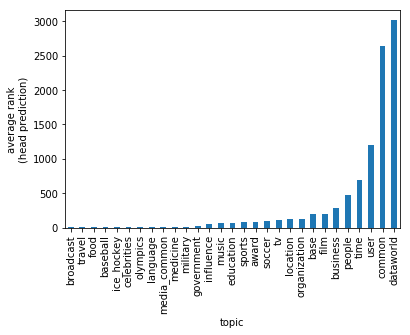

examples for "easy" topics:

example for topic broadcast: /broadcast/content/artist
example for topic travel: /travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
example for topic food: /food/food/nutrients./food/nutrition_fact/nutrient
example for topic baseball: /baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
example for topic ice_hockey: /ice_hockey/hockey_team/current_roster./sports/sports_team_roster/position


examples for "difficult" topics:

example for topic people: /people/person/gender
example for topic time: /time/event/instance_of_recurring_event
example for topic user: /user/ktrueman/default_domain/international_organization/member_states
example for topic common: /common/topic/webpage./common/webpage/category
example for topic dataworld: /dataworld/gardening_hint/split_to


In [7]:
# analyse prediction_table_head.pkl
# find "easy" relations (relations that are part of triples with a good rank) and "difficult" relations
print('easy relations for head prediction (10 relations with the lowest average rank):\n')
for row in prediction_table_h[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank').head(10).iterrows():
    print(id2relation[row[0]])

print('\n\n\ndifficult relations for head prediction (10 relations with the highest average rank):\n')
for row in prediction_table_h[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank', ascending=False).head(10).iterrows():
    print(id2relation[row[0]])
    
print('\n\n\naverage rank of each topic (head prediction):')

df = prediction_table_h[['topic', 'rank']].groupby('topic', as_index=False)['rank'].mean().\
                                           sort_values(by='rank')
ax = df.plot.bar(x='topic', y='rank', rot=90, legend=False).set_ylabel('average rank\n(head prediction)')
plt.show()

# find examples for the "easy" topics
print('examples for "easy" topics:\n')
for index, topic in df.head(5)['topic'].iteritems():
    for index, row in prediction_table_h[['p', 'rank', 'topic']].sort_values(by='rank')[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

print('\n\nexamples for "difficult" topics:\n')
# find examples for the "difficult" topics
for index, topic in df.tail(5)['topic'].iteritems():
    for index, row in prediction_table_h[['p', 'rank', 'topic']].sort_values(by='rank', ascending=True)[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

proportion of relation types: {'n:m': 0.762, '1:n': 0.206, 'n:1': 0.024, '1:1': 0.008}


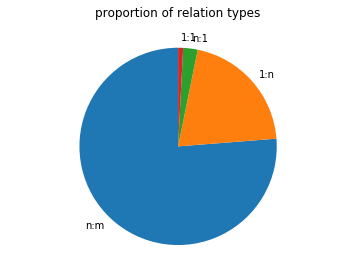

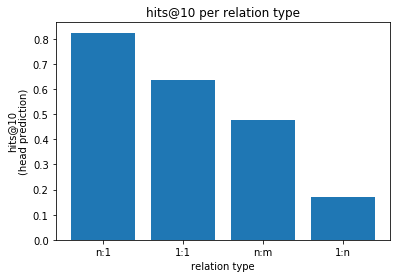

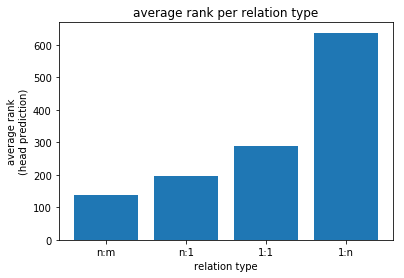

Hint: higher is better for hits@10, lower is better for the average rank



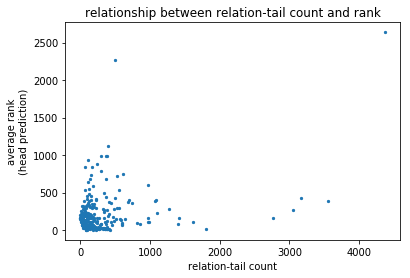

In [8]:
# analyse prediction_table_head.pkl
# plot relationship between relation-tail count and rank
rel_tail_count_to_avg_rank = dict()
relation_type_to_avg_rank = dict()  # keys: 1:1, 1:n, n:1, n:m
relation_type_to_hits10 = defaultdict(int)
relation_type_count = defaultdict(int)

for index, row in prediction_table_h.iterrows():
    relation_type = relation2type[row['p']]
    if row['rank'] <= 10:
        relation_type_to_hits10[relation_type] += 1
    relation_type_count[relation_type] += 1
        
    if relation_type not in relation_type_to_avg_rank:
        relation_type_to_avg_rank[relation_type] = (row['rank'], 1)
    else:
        relation_type_to_avg_rank[relation_type] = (relation_type_to_avg_rank[relation_type][0] +
                                                   row['rank'],
                                                   relation_type_to_avg_rank[relation_type][1] + 1)

    count_left = head_rel_count[(row['s'], row['p'])]
    count_right = rel_tail_count[(row['p'], row['o'])]
    if count_right not in rel_tail_count_to_avg_rank:
        rel_tail_count_to_avg_rank[count_right] = (row['rank'], 1)
    else:
        rel_tail_count_to_avg_rank[count_right] = (rel_tail_count_to_avg_rank[count_right][0] +
                                                   row['rank'],
                                                   rel_tail_count_to_avg_rank[count_right][1] + 1)

values_sum = sum(relation_type_count.values())
relation_type_to_proportion = {relation_type: round(count / values_sum, 3)
                               for relation_type, count in relation_type_count.items()}
print('proportion of relation types: ' + str(relation_type_to_proportion))

labels = sorted(relation_type_count, key=relation_type_count.get, reverse=True)
sizes = [relation_type_count[label] for label in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=False, startangle=90)
ax1.axis('equal')
plt.title('proportion of relation types\n')
plt.show()

for relation_type in relation_type_to_hits10:
    relation_type_to_hits10[relation_type] = relation_type_to_hits10[relation_type] \
                                             / relation_type_count[relation_type]

x = []
y = []
for relation_type in sorted(relation_type_to_hits10, key=relation_type_to_hits10.get, reverse=True):
    x.append(relation_type)
    y.append(relation_type_to_hits10[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('hits@10 per relation type')
plt.xlabel('relation type')
plt.ylabel('hits@10\n(head prediction)')
plt.show()
print()

for relation_type, (sum_rank, num) in relation_type_to_avg_rank.items():
    relation_type_to_avg_rank[relation_type] = sum_rank / num

x = []
y = []
for relation_type in sorted(relation_type_to_avg_rank, key=relation_type_to_avg_rank.get):
    x.append(relation_type)
    y.append(relation_type_to_avg_rank[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('average rank per relation type')
plt.xlabel('relation type')
plt.ylabel('average rank\n(head prediction)')
plt.show()

print('Hint: higher is better for hits@10, lower is better for the average rank\n')

for count, (sum_rank, num) in rel_tail_count_to_avg_rank.items():
    rel_tail_count_to_avg_rank[count] = sum_rank / num

x = []
y = []
for count in sorted(rel_tail_count_to_avg_rank):
    x.append(count)
    y.append(rel_tail_count_to_avg_rank[count])
    
plt.figure()
plt.title('relationship between relation-tail count and rank')
plt.xlabel('relation-tail count')
plt.ylabel('average rank\n(head prediction)')
plt.scatter(x, y, s=5)
plt.show()

In [9]:
# analyse prediction_table_head.pkl
# when is the models ranking bad? is there specific a pattern?
mask = prediction_table_h['rank'] > int(14541/2)  # 14541 = num diff. entities
prediction_table_bad = prediction_table_h[mask]
print('There are {} very bad head predictions:'.format(prediction_table_bad.shape[0]))
print('Hint: the numbers stand for a property of the corresponding triple (see more below)\n')

error_id_count = defaultdict(int)
triples_count = 0
rel_tail_counts_bad = set()
for index, row in prediction_table_bad.iterrows():
    rel_tail_counts_bad.add(rel_tail_count[(row[1], row[2])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]

    head_id = torch.tensor([row[0]]).cuda()
    relation_id = torch.tensor([row[1]]).cuda()
    tail_id = torch.tensor([row[2]]).cuda()
    scores_subject = model.predict_subject_scores(head_id, relation_id, tail_id)
    argsort_subject = torch.argsort(scores_subject, dim=1, descending=True)
    models_top10 = []
    for entity_id in argsort_subject[0][:10]:
        try:
            entity_name = mid2name[id2entity[entity_id.item()]]
            models_top10.append(entity_name)
        except:  # entity unknown
            pass
            
    # rank_subject = (argsort_subject == head_id).nonzero()
    # rank_subject = 1 + rank_subject[0][1].item()
    # assert rank_subject == row[3]

    try:
        mid2name[tail]
        print('\ncorrect head: ' + mid2name[head])
        print('given relation: ' + relation)
        print('given tail: ' + mid2name[tail])
        print('instead of the correct entity these entities got a high score:\n')
        error_type_table = pd.DataFrame(columns=['entity name']+[i for i in range(8)])
        for entity_name in models_top10:
            try: 
                triple = (mid2name[head], relation, mid2name[tail])
                error_type = get_error_type(triple, predicted=entity_name, mode='head')
                row_dict = {'entity name': entity_name}
                row_dict.update({error_id: 'x' for error_id in error_type})
                error_type_table = error_type_table.append(row_dict, ignore_index=True)
                for error_id in error_type:
                    error_id_count[error_id] += 1
                triples_count += 1
            except Exception as e:
                print(e)
        print(error_type_table.fillna('').to_string(index=False))
        print()
    except:  # entity unknown
        pass

print('\n\ndescription for every error_id: ' + str(error_id2description_head))

error_id2percentage = {error_id: round(error_id_count[error_id] / triples_count, 3)
                       for error_id in error_id_count}
error_id2percentage = sorted(error_id2percentage.items())
print('\npercentage of very bad head predictions with the corresponding error_id: ' + str(error_id2percentage))

avg_rel_tail_count_bad = sum(rel_tail_counts_bad) / len(rel_tail_counts_bad)
print('\naverage relation-tail count for these very bad head predictions: ' + str(avg_rel_tail_count_bad))

There are 73 very bad head predictions:
Hint: the numbers stand for a property of the corresponding triple (see more below)

tensor([[[-0.0254,  0.0048,  0.0060,  ...,  0.0190, -0.0048, -0.0190],
         [-0.0040,  0.0042,  0.0005,  ...,  0.0057,  0.0048, -0.0025],
         [-0.0254,  0.0048,  0.0060,  ...,  0.0190, -0.0048, -0.0190],
         ...,
         [-0.0094,  0.0087,  0.0016,  ...,  0.0020, -0.0017, -0.0177],
         [-0.0254,  0.0048,  0.0060,  ...,  0.0190, -0.0048, -0.0190],
         [-0.0254,  0.0048,  0.0060,  ...,  0.0190, -0.0048, -0.0190]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0004,  0.0013, -0.0110,  ..., -0.0138, -0.0005, -0.0041],
         [-0.0048,  0.0041, -0.0089,  ...,  0.0034, -0.0026, -0.0046],
         [ 0.0004,  0.0013, -0.0110,  ..., -0.0138, -0.0005, -0.0041],
         ...,
         [-0.0015,  0.0041, -0.0009,  ...,  0.0009, -0.0029, -0.0099],
         [ 0.0004,  0.0013, -0.0110,  ..., -0.0138, -0.0005, -0.0041],
         [ 0.000

         entity name 0 1 2  3  4  5  6 7
      United Kingdom        x  x  x  x  
         South Korea        x  x  x  x  
       New York City        x  x  x  x  
           Hong Kong        x  x  x  x  
         Los Angeles        x  x  x  x  
              Taiwan        x  x  x  x  
 Antigua and Barbuda        x  x  x  x  
              French        x  x  x  x  
           Singapore        x  x  x  x  

tensor([[[-0.0011,  0.0068,  0.0071,  ..., -0.0056,  0.0037, -0.0165],
         [-0.0040,  0.0042,  0.0005,  ...,  0.0057,  0.0048, -0.0025],
         [-0.0011,  0.0068,  0.0071,  ..., -0.0056,  0.0037, -0.0165],
         ...,
         [-0.0094,  0.0087,  0.0016,  ...,  0.0020, -0.0017, -0.0177],
         [-0.0011,  0.0068,  0.0071,  ..., -0.0056,  0.0037, -0.0165],
         [-0.0011,  0.0068,  0.0071,  ..., -0.0056,  0.0037, -0.0165]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0018,  0.0035,  0.0012,  ...,  0.0096,  0.0062, -0.0117],
         [-0.0048,  0.0041, 

tensor([[[ 0.0071,  0.0031,  0.0076,  ..., -0.0002,  0.0024, -0.0205],
         [-0.0040,  0.0042,  0.0005,  ...,  0.0057,  0.0048, -0.0025],
         [ 0.0071,  0.0031,  0.0076,  ..., -0.0002,  0.0024, -0.0205],
         ...,
         [-0.0094,  0.0087,  0.0016,  ...,  0.0020, -0.0017, -0.0177],
         [ 0.0071,  0.0031,  0.0076,  ..., -0.0002,  0.0024, -0.0205],
         [ 0.0071,  0.0031,  0.0076,  ..., -0.0002,  0.0024, -0.0205]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[-0.0015,  0.0046,  0.0015,  ...,  0.0083, -0.0041, -0.0176],
         [-0.0048,  0.0041, -0.0089,  ...,  0.0034, -0.0026, -0.0046],
         [-0.0015,  0.0046,  0.0015,  ...,  0.0083, -0.0041, -0.0176],
         ...,
         [-0.0015,  0.0041, -0.0009,  ...,  0.0009, -0.0029, -0.0099],
         [-0.0015,  0.0046,  0.0015,  ...,  0.0083, -0.0041, -0.0176],
         [-0.0015,  0.0046,  0.0015,  ...,  0.0083, -0.0041, -0.0176]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0024, -

tensor([[[ 0.0139, -0.0075, -0.0132,  ...,  0.0136,  0.0202, -0.0064],
         [-0.0040,  0.0042,  0.0005,  ...,  0.0057,  0.0048, -0.0025],
         [ 0.0139, -0.0075, -0.0132,  ...,  0.0136,  0.0202, -0.0064],
         ...,
         [-0.0094,  0.0087,  0.0016,  ...,  0.0020, -0.0017, -0.0177],
         [ 0.0139, -0.0075, -0.0132,  ...,  0.0136,  0.0202, -0.0064],
         [ 0.0139, -0.0075, -0.0132,  ...,  0.0136,  0.0202, -0.0064]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0107, -0.0149,  0.0153,  ...,  0.0141, -0.0031, -0.0213],
         [-0.0048,  0.0041, -0.0089,  ...,  0.0034, -0.0026, -0.0046],
         [ 0.0107, -0.0149,  0.0153,  ...,  0.0141, -0.0031, -0.0213],
         ...,
         [-0.0015,  0.0041, -0.0009,  ...,  0.0009, -0.0029, -0.0099],
         [ 0.0107, -0.0149,  0.0153,  ...,  0.0141, -0.0031, -0.0213],
         [ 0.0107, -0.0149,  0.0153,  ...,  0.0141, -0.0031, -0.0213]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0017, -

                                       entity name 0 1 2 3 4  5  6 7
 Golden Raspberry Award for Worst Screen Couple...            x  x  
                     MTV Movie Award for Best Kiss            x     
            Golden Raspberry Award for Worst Actor            x     
 Golden Raspberry Award for Worst Supporting Actor            x     
 Golden Raspberry Award for Worst Supporting Ac...            x     
 MTV Movie Award for Best Breakthrough Performance            x     
         Golden Raspberry Award for Worst New Star            x  x  
          Golden Raspberry Award for Worst Actress            x     
                     Presidential Medal of Freedom            x  x  
            MTV Movie Award for Best On-Screen Duo            x     

tensor([[[ 0.0052, -0.0036,  0.0126,  ..., -0.0010, -0.0055,  0.0128],
         [-0.0014,  0.0078,  0.0033,  ...,  0.0046, -0.0028, -0.0047],
         [ 0.0039,  0.0079,  0.0101,  ..., -0.0187, -0.0056, -0.0024],
         ...,
         [-0.

                                       entity name 0 1 2  3  4  5  6 7
                Library of Congress Classification        x  x  x  x  
                                      Warner Bros.        x  x  x     
                         2000 Cannes Film Festival        x  x  x  x  
                 University of Southern California        x  x  x     
 Grammy Award for Best Country Instrumental Per...        x  x  x  x  
                                     male organism        x  x  x  x  
 United States Department of Housing and Urban ...        x  x  x     
                             Universal Music Group        x  x  x     
                                           Judaism        x  x  x  x  

tensor([[[ 0.0056,  0.0023,  0.0100,  ..., -0.0025, -0.0081,  0.0155],
         [-0.0009,  0.0138,  0.0006,  ...,  0.0031, -0.0053, -0.0020],
         [ 0.0043,  0.0139,  0.0074,  ..., -0.0202, -0.0081,  0.0003],
         ...,
         [-0.0064,  0.0182,  0.0018,  ..., -0.0007, -0.0119, -

         entity name 0 1 2  3  4  5  6 7
      United Kingdom        x  x  x  x  
         South Korea        x  x  x  x  
       New York City        x  x  x  x  
           Hong Kong        x  x  x  x  
         Los Angeles        x  x  x  x  
              Taiwan        x  x  x  x  
 Antigua and Barbuda        x  x  x  x  
              French        x  x  x  x  
           Singapore        x  x  x  x  

tensor([[[ 0.0156,  0.0135,  0.0130,  ...,  0.0108, -0.0083,  0.0171],
         [-0.0040,  0.0042,  0.0005,  ...,  0.0057,  0.0048, -0.0025],
         [ 0.0156,  0.0135,  0.0130,  ...,  0.0108, -0.0083,  0.0171],
         ...,
         [-0.0094,  0.0087,  0.0016,  ...,  0.0020, -0.0017, -0.0177],
         [ 0.0156,  0.0135,  0.0130,  ...,  0.0108, -0.0083,  0.0171],
         [ 0.0156,  0.0135,  0.0130,  ...,  0.0108, -0.0083,  0.0171]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0060,  0.0119, -0.0073,  ..., -0.0103, -0.0103,  0.0044],
         [-0.0048,  0.0041, 

tensor([[[ 0.0075, -0.0048,  0.0157,  ...,  0.0007, -0.0058,  0.0084],
         [ 0.0009,  0.0067,  0.0064,  ...,  0.0062, -0.0031, -0.0091],
         [ 0.0062,  0.0068,  0.0132,  ..., -0.0171, -0.0059, -0.0068],
         ...,
         [-0.0045,  0.0111,  0.0075,  ...,  0.0025, -0.0096, -0.0244],
         [ 0.0123,  0.0091,  0.0077,  ..., -0.0020, -0.0103, -0.0235],
         [-0.0045,  0.0069,  0.0077,  ..., -0.0038, -0.0098, -0.0239]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0120, -0.0098, -0.0052,  ...,  0.0001, -0.0041,  0.0122],
         [ 0.0087, -0.0020, -0.0092,  ...,  0.0049, -0.0049,  0.0069],
         [ 0.0123, -0.0017, -0.0020,  ...,  0.0237, -0.0040,  0.0115],
         ...,
         [ 0.0121, -0.0021, -0.0011,  ...,  0.0024, -0.0052,  0.0017],
         [ 0.0105, -0.0067, -0.0006,  ...,  0.0042, -0.0032,  0.0231],
         [ 0.0120, -0.0018, -0.0006,  ...,  0.0027, -0.0051,  0.0189]]],
       device='cuda:0', grad_fn=<SubBackward0>)

correct head: curat

tensor([[[-0.0006, -0.0082,  0.0100,  ...,  0.0003,  0.0005,  0.0337],
         [-0.0072,  0.0033,  0.0006,  ...,  0.0059,  0.0033,  0.0162],
         [-0.0019,  0.0033,  0.0074,  ..., -0.0174,  0.0004,  0.0185],
         ...,
         [-0.0126,  0.0077,  0.0018,  ...,  0.0021, -0.0033,  0.0010],
         [ 0.0042,  0.0057,  0.0020,  ..., -0.0024, -0.0039,  0.0018],
         [-0.0126,  0.0035,  0.0020,  ..., -0.0042, -0.0035,  0.0014]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0021,  0.0029, -0.0053,  ...,  0.0009,  0.0028, -0.0117],
         [-0.0012,  0.0106, -0.0092,  ...,  0.0057,  0.0020, -0.0169],
         [ 0.0024,  0.0110, -0.0020,  ...,  0.0245,  0.0030, -0.0124],
         ...,
         [ 0.0022,  0.0105, -0.0011,  ...,  0.0032,  0.0018, -0.0222],
         [ 0.0006,  0.0059, -0.0006,  ...,  0.0050,  0.0037, -0.0008],
         [ 0.0021,  0.0108, -0.0007,  ...,  0.0035,  0.0019, -0.0050]]],
       device='cuda:0', grad_fn=<SubBackward0>)

correct head: Pulit

tensor([[[ 0.0032, -0.0065,  0.0109,  ..., -0.0050, -0.0055,  0.0210],
         [-0.0034,  0.0049,  0.0016,  ...,  0.0006, -0.0028,  0.0034],
         [ 0.0019,  0.0050,  0.0084,  ..., -0.0227, -0.0056,  0.0058],
         ...,
         [-0.0088,  0.0094,  0.0027,  ..., -0.0032, -0.0094, -0.0118],
         [ 0.0080,  0.0074,  0.0029,  ..., -0.0077, -0.0100, -0.0110],
         [-0.0088,  0.0052,  0.0029,  ..., -0.0095, -0.0095, -0.0113]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[-0.0041,  0.0055,  0.0026,  ...,  0.0013,  0.0022, -0.0025],
         [-0.0074,  0.0133, -0.0014,  ...,  0.0061,  0.0014, -0.0078],
         [-0.0038,  0.0136,  0.0058,  ...,  0.0249,  0.0023, -0.0032],
         ...,
         [-0.0040,  0.0132,  0.0067,  ...,  0.0036,  0.0011, -0.0131],
         [-0.0056,  0.0086,  0.0072,  ...,  0.0054,  0.0031,  0.0084],
         [-0.0041,  0.0135,  0.0072,  ...,  0.0039,  0.0013,  0.0042]]],
       device='cuda:0', grad_fn=<SubBackward0>)

correct head: Nobel

                                entity name 0 1 2 3 4  5  6 7
           Filmfare Award for Best Director            x  x  
              Filmfare Award for Best Actor            x  x  
   Filmfare Award for Best Supporting Actor            x  x  
                  BAFTA Award for Best Film            x  x  
            Academy Award for Best Director            x     
               Filmfare Award for Best Film            x  x  
             Academy Award for Best Picture            x  x  
                                Golden Lion            x  x  
 Academy Award for Best Original Screenplay            x  x  
       Golden Globe Award for Best Director            x     

tensor([[[ 0.0123, -0.0121,  0.0106,  ...,  0.0006,  0.0054,  0.0340],
         [ 0.0057, -0.0007,  0.0013,  ...,  0.0061,  0.0082,  0.0165],
         [ 0.0110, -0.0006,  0.0081,  ..., -0.0172,  0.0054,  0.0188],
         ...,
         [ 0.0003,  0.0038,  0.0024,  ...,  0.0024,  0.0016,  0.0012],
         [ 0.0171, 

tensor([[[ 0.0093, -0.0107,  0.0100,  ..., -0.0121, -0.0037,  0.0033],
         [ 0.0028,  0.0008,  0.0006,  ..., -0.0065, -0.0009, -0.0142],
         [ 0.0080,  0.0009,  0.0074,  ..., -0.0298, -0.0038, -0.0119],
         ...,
         [-0.0027,  0.0053,  0.0017,  ..., -0.0103, -0.0075, -0.0294],
         [ 0.0141,  0.0032,  0.0019,  ..., -0.0148, -0.0081, -0.0286],
         [-0.0027,  0.0011,  0.0020,  ..., -0.0165, -0.0077, -0.0289]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0132,  0.0090,  0.0065,  ..., -0.0049, -0.0137,  0.0210],
         [ 0.0100,  0.0167,  0.0026,  ..., -0.0001, -0.0145,  0.0158],
         [ 0.0135,  0.0171,  0.0097,  ...,  0.0187, -0.0136,  0.0203],
         ...,
         [ 0.0133,  0.0167,  0.0106,  ..., -0.0026, -0.0148,  0.0105],
         [ 0.0117,  0.0121,  0.0111,  ..., -0.0008, -0.0128,  0.0319],
         [ 0.0133,  0.0169,  0.0111,  ..., -0.0023, -0.0146,  0.0277]]],
       device='cuda:0', grad_fn=<SubBackward0>)

correct head: Kuwai

In [10]:
# analyse prediction_table_head.pkl
# when is the models ranking good? is there specific a pattern?
mask = prediction_table_h['rank'] == 1
prediction_table_perfect_h = prediction_table_h[mask]
print('There are {} perfect head predictions:\n'.format(prediction_table_perfect_h.shape[0]))

rel_tail_counts_good = set()
for index, row in prediction_table_perfect_h.iterrows():
    rel_tail_counts_good.add(rel_tail_count[(row[1], row[2])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]
    try:
        mid2name[tail]
        print(mid2name[head])
        print(relation)
        print(mid2name[tail])
        print()
    except:  # entity unknown
        pass

avg_rel_tail_count_good = sum(rel_tail_counts_good) / len(rel_tail_counts_good)
print('average relation-tail count for these good head predictions: ' + str(avg_rel_tail_count_good))

There are 3078 perfect head predictions:

Zürich
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
October

England
/location/location/contains
Lancaster

prime minister
/government/government_office_category/officeholders./government/government_position_held/jurisdiction_of_office
Liechtenstein

2008 Summer Olympics
/olympics/olympic_games/participating_countries
Djibouti

2008 Summer Olympics
/olympics/olympic_games/participating_countries
Mauritania

Grammy Award for Best Country Album
/award/award_category/winners./award/award_honor/ceremony
2001 Grammy Awards

Grammy Award for Best Country Album
/award/award_category/winners./award/award_honor/ceremony
2000 Grammy Awards

Screen Actors Guild Award for Outstanding Performance by a Male Actor in a Supporting Role
/award/award_category/nominees./award/award_nomination/nominated_for
As Good as It Gets

The Beaver
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Brazil

Lo

Brazil

Strawberries
/food/food/nutrients./food/nutrition_fact/nutrient
linoleic acid

Taken
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Singapore

2nd United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Pennsylvania

New York City
/location/location/time_zones
Eastern Time Zone

United States of America
/location/location/contains
University of North Dakota

freestyle wrestling
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
Iran

Grammy Award for Best Rap Performance by a Duo or Group
/award/award_category/winners./award/award_honor/ceremony
2005 Grammy Awards

rhythm and blues
/music/genre/artists
Tina Turner

Keith David
/people/person/profession
actor

Kris Kristofferson
/people/person/spouse_s./people/marriage/type_of_union
marriage

Academy Award for Best Writing, Adapted Screenplay
/award/award_category/winners./award/award_honor/ceremony
55th A


bluegrass music
/music/genre/artists
Ricky Skaggs

Oslo
/travel/travel_destination/how_to_get_here./travel/transportation/mode_of_transportation
train

Academy Award for Best Picture
/award/award_category/winners./award/award_honor/ceremony
71st Academy Awards

Academy Award for Best Picture
/award/award_category/winners./award/award_honor/ceremony
61st Academy Awards

Irish Americans
/people/ethnicity/people
Katherine Heigl

progressive rock
/music/genre/artists
King Crimson

112th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Nebraska

Thousand Oaks
/location/hud_county_place/place
Thousand Oaks

Academy Award for Best Supporting Actor
/award/award_category/winners./award/award_honor/ceremony
82nd Academy Awards

track and field
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
Japan

dean
/organization/role/leaders./organization/leadership/organization
Harvard Law School

Chicago

Foo Fighters

Huntsville
/location/hud_county_place/place
Huntsville

violin
/music/instrument/instrumentalists
Joseph Haydn

St. Louis Cardinals
/baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
2000 Major League Baseball season

swimming
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
Grenada

swimming
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
Serbia

swimming
/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country
Portugal

Mediterranean Sea
/location/location/partially_contains
Italy

18th Screen Actors Guild Awards
/award/award_ceremony/awards_presented./award/award_honor/award_winner
Jack Huston

Primetime Emmy Award for Outstanding Drama Series
/award/award_category/nominees./award/award_nomination/nominated_for
Deadwood

classical music
/music/genre/artists
Isaac Stern

United Kingdom
/location/location/contains
Fitzwilliam College

Mommie Dearest
/award/award_winnin


18th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Louisiana

50 First Dates
/film/film/genre
comedy

15th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Pennsylvania

61st Primetime Emmy Awards
/award/award_ceremony/awards_presented./award/award_honor/honored_for
The Amazing Race

jazz
/music/genre/artists
Chris Thile

carrot
/food/food/nutrients./food/nutrition_fact/nutrient
L-phenylalanine

How to Train Your Dragon
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Croatia

Satellite Awards 2007
/award/award_ceremony/awards_presented./award/award_honor/honored_for
Michael Clayton

Critics' Choice Movie Award for Best Animated Feature
/award/award_category/nominees./award/award_nomination/nominated_for
Madagascar 3: Europe's Most Wanted

track and field
/olympics/olympic_sport/athletes./olympics/olympic_athle

United Kingdom

Primetime Emmy Award for Outstanding Supporting Actress in a Comedy Series
/award/award_category/category_of
Primetime Emmy Award

Latin Americans
/location/location/contains
Panama

Screen Actors Guild Award for Outstanding Performance by a Female Actor in a Supporting Role
/award/award_category/nominees./award/award_nomination/nominated_for
Nine

George Harrison: Living in the Material World
/film/film/personal_appearances./film/personal_film_appearance/person
Eric Clapton

1952 Summer Olympics
/olympics/olympic_games/participating_countries
Sri Lanka

musical
/music/genre/artists
Robert B. Sherman

RCA Records
/music/record_label/artist
Mark Ronson

jazz fusion
/music/genre/artists
The Mothers of Invention

The Artist
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Russia

Finding Nemo
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Belgium

bass guitar
/music/performance_role/regular_performances./music/g

silver medal

Indian American
/people/ethnicity/languages_spoken
Urdu

Academy Award for Best Film Editing
/award/award_category/winners./award/award_honor/ceremony
23rd Academy Awards

24th Academy Awards
/award/award_ceremony/awards_presented./award/award_honor/award_winner
Cedric Gibbons

Denver
/base/petbreeds/city_with_dogs/top_breeds./base/petbreeds/dog_city_relationship/dog_breed
Yorkshire Terrier

Jewish people
/people/ethnicity/people
Jesus Christ

107th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Idaho

Golden Raspberry Award for Worst Actor
/award/award_category/nominees./award/award_nomination/nominated_for
End of Days

White American
/people/ethnicity/languages_spoken
Serbo-Croatian

9th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Pennsylvania

Michael Gough
/film/actor/film./film/performance/film
Batman

Middle East
/loc

In [11]:
# load prediction_table_tail.pkl
path = os.path.join(model_output_path, 'prediction_table_tail.pkl')
prediction_table_tail = pd.read_pickle(path)
prediction_table_tail['rank of true tail'] = pd.to_numeric(prediction_table_tail['rank of true tail'],
                                                           downcast='integer')

s = []
p = []
o = []
topics = []
for _, triple_str in prediction_table_tail['triple'].iteritems():
    triple = re.split(',', triple_str[1:-1])
    s.append(int(triple[0].strip()))
    p.append(int(triple[1].strip()))
    o.append(int(triple[2].strip()))
    topics.append(id2relation[int(triple[1].strip())].split('/')[1])

prediction_table_t = pd.DataFrame(columns=['s', 'p', 'o', 'rank'])
prediction_table_t['s'] = s
prediction_table_t['p'] = p
prediction_table_t['o'] = o
prediction_table_t['rank'] = prediction_table_tail['rank of true tail']
prediction_table_t['topic'] = topics

easy relations for tail prediction (10 relations with the lowest average rank):

/location/country/official_language
/location/location/adjoin_s./location/adjoining_relationship/adjoins
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source
/location/country/second_level_divisions
/education/educational_degree/people_with_this_degree./education/education/student
/location/administrative_division/country
/language/human_language/countries_spoken_in
/music/genre/artists
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
/film/actor/film./film/performance/film



difficult relations for tail prediction (10 relations with the highest average rank):

/base/biblioness/bibs_location/country
/sports/sport/pro_athletes./sports/pro_sports_played/athlete
/sports/sports_team_location/teams
/business/business_operation/operating_income./measurement_unit/dated_money_value/currency
/olympics/olympic_participating_country

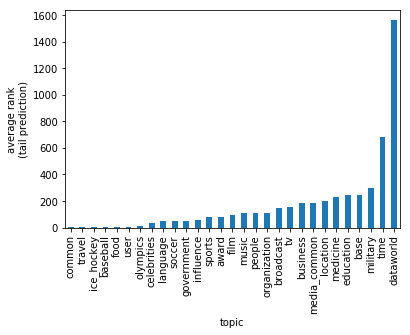

examples for "easy" topics:

example for topic common: /common/topic/webpage./common/webpage/category
example for topic travel: /travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
example for topic ice_hockey: /ice_hockey/hockey_team/current_roster./sports/sports_team_roster/position
example for topic baseball: /baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
example for topic food: /food/food/nutrients./food/nutrition_fact/nutrient


examples for "difficult" topics:

example for topic education: /education/educational_institution/students_graduates./education/education/student
example for topic base: /base/culturalevent/event/entity_involved
example for topic military: /military/military_conflict/combatants./military/military_combatant_group/combatants
example for topic time: /time/event/instance_of_recurring_event
example for topic dataworld: /dataworld/gardening_hint/split_to


In [12]:
# analyse prediction_table_tail.pkl
# find "easy" relations (relations that are part of triples with a good rank) and "difficult" relations

print('easy relations for tail prediction (10 relations with the lowest average rank):\n')
for row in prediction_table_t[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank').head(10).iterrows():
    print(id2relation[row[0]])

print('\n\n\ndifficult relations for tail prediction (10 relations with the highest average rank):\n')
for row in prediction_table_t[['p', 'rank']].groupby('p', as_index=False)['rank'].mean().\
                                             sort_values(by='rank', ascending=False).head(10).iterrows():
    print(id2relation[row[0]])
    
print('\n\n\naverage rank of each topic (tail prediction:')
df = prediction_table_t[['topic', 'rank']].groupby('topic', as_index=False)['rank'].mean().\
                                           sort_values(by='rank')
ax = df.plot.bar(x='topic', y='rank', rot=90, legend=False).set_ylabel('average rank\n(tail prediction)')
plt.savefig(fname='topics_rotate3', dpi=1000)
plt.show()

# find examples for the "easy" topics
print('examples for "easy" topics:\n')
for index, topic in df.head(5)['topic'].iteritems():
    for index, row in prediction_table_t[['p', 'rank', 'topic']].sort_values(by='rank')[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

# find examples for the "difficult" topics
print('\n\nexamples for "difficult" topics:\n')
for index, topic in df.tail(5)['topic'].iteritems():
    for index, row in prediction_table_t[['p', 'rank', 'topic']].sort_values(by='rank', ascending=False)[['p', 'topic']].iterrows():
        if row['topic'] == topic:
            print('example for topic {}: {}'.format(topic, id2relation[row['p']]))
            break

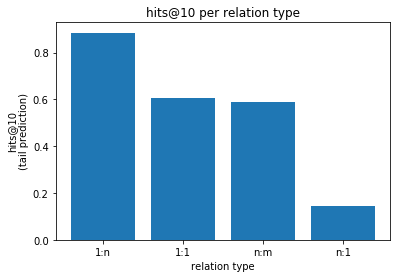

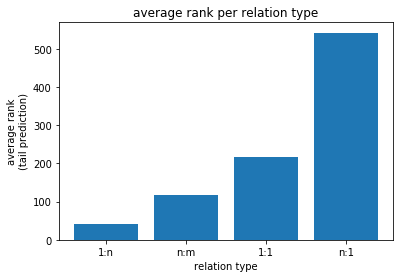

Hint: higher is better for hits@10, lower is better for the average rank



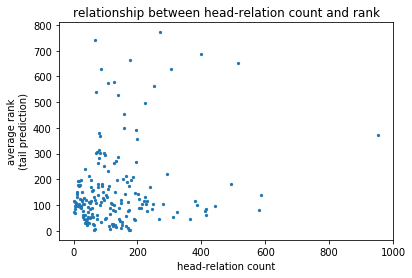

In [13]:
# analyse prediction_table_tail.pkl
# plot relationship between head-relation count and rank
head_rel_count_to_avg_rank = dict()
relation_type_to_avg_rank = dict()
relation_type_to_hits10 = defaultdict(int)
relation_type_count = defaultdict(int)

for index, row in prediction_table_t.iterrows():
    relation_type = relation2type[row['p']]
    if row['rank'] <= 10:
        relation_type_to_hits10[relation_type] += 1
    relation_type_count[relation_type] += 1

    if relation_type not in relation_type_to_avg_rank:
        relation_type_to_avg_rank[relation_type] = (row['rank'], 1)
    else:
        relation_type_to_avg_rank[relation_type] = (relation_type_to_avg_rank[relation_type][0] +
                                                    row['rank'],
                                                    relation_type_to_avg_rank[relation_type][1] + 1)

    count_left = head_rel_count[(row['s'], row['p'])]
    count_right = rel_tail_count[(row['p'], row['o'])]
    if count_left not in head_rel_count_to_avg_rank:
        head_rel_count_to_avg_rank[count_left] = (row['rank'], 1)
    else:
        head_rel_count_to_avg_rank[count_left] = (head_rel_count_to_avg_rank[count_left][0] +
                                                  row['rank'],
                                                  head_rel_count_to_avg_rank[count_left][1] + 1)

for relation_type in relation_type_to_hits10:
    relation_type_to_hits10[relation_type] = relation_type_to_hits10[relation_type] \
                                             / relation_type_count[relation_type]

x = []
y = []
for relation_type in sorted(relation_type_to_hits10, key=relation_type_to_hits10.get, reverse=True):
    x.append(relation_type)
    y.append(relation_type_to_hits10[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('hits@10 per relation type')
plt.xlabel('relation type')
plt.ylabel('hits@10\n(tail prediction)')
plt.show()
print()

for relation_type, (sum_rank, num) in relation_type_to_avg_rank.items():
    relation_type_to_avg_rank[relation_type] = sum_rank / num

x = []
y = []
for relation_type in sorted(relation_type_to_avg_rank, key=relation_type_to_avg_rank.get):
    x.append(relation_type)
    y.append(relation_type_to_avg_rank[relation_type])
plt.bar(range(len(x)), y)
plt.xticks(range(len(x)), x)
plt.title('average rank per relation type')
plt.xlabel('relation type')
plt.ylabel('average rank\n(tail prediction)')
plt.show()

print('Hint: higher is better for hits@10, lower is better for the average rank\n')

for count, (sum_avg_rank, num) in head_rel_count_to_avg_rank.items():
    head_rel_count_to_avg_rank[count] = sum_avg_rank / num

x = []
y = []
for count in sorted(head_rel_count_to_avg_rank):
    x.append(count)
    y.append(head_rel_count_to_avg_rank[count])
    
plt.figure()
plt.title('relationship between head-relation count and rank')
plt.xlabel('head-relation count')
plt.ylabel('average rank\n(tail prediction)')
plt.scatter(x, y, s=5)
plt.show()

In [14]:
# analyse prediction_table_tail.pkl
# when is the models ranking bad? is there specific a pattern?
mask = prediction_table_t['rank'] > int(14541/2)  # 14541 = num diff. entities
prediction_table_bad = prediction_table_t[mask]
print('There are {} very bad tail predictions:'.format(prediction_table_bad.shape[0]))
print('Hint: the numbers stand for a property of the corresponding triple (see more below)\n')

error_id_count = defaultdict(int)
triples_count = 0
head_rel_counts_bad = set()
for index, row in prediction_table_bad.iterrows():
    head_rel_counts_bad.add(head_rel_count[(row[0], row[1])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]

    head_id = torch.tensor([row[0]]).cuda()
    relation_id = torch.tensor([row[1]]).cuda()
    tail_id = torch.tensor([row[2]]).cuda()
    scores_object = model.predict_object_scores(head_id, relation_id, tail_id)
    argsort_object = torch.argsort(scores_object, dim=1, descending=True)
    models_top10 = []
    for entity_id in argsort_object[0][:10]:
        try:
            entity_name = mid2name[id2entity[entity_id.item()]]
            models_top10.append(entity_name)
        except:  # entity unknown
            pass
        
    # rank_object = (argsort_object == tail_id).nonzero()
    # rank_object = 1 + rank_object[0][1].item()
    # assert rank_object == row[3]

    try:
        mid2name[tail]
        print('\ngiven head: ' + mid2name[head])
        print('given relation: ' + relation)
        print('correct tail: ' + mid2name[tail])
        print('instead of the correct entity these entities got a high score: ')
        error_type_table = pd.DataFrame(columns=['entity name']+[i for i in range(8)])
        for entity_name in models_top10:
            try: 
                triple = (mid2name[head], relation, mid2name[tail])
                error_type = get_error_type(triple, predicted=entity_name, mode='tail')
                row_dict = {'entity name': entity_name}
                row_dict.update({error_id: 'x' for error_id in error_type})
                error_type_table = error_type_table.append(row_dict, ignore_index=True)
                for error_id in error_type:
                    error_id_count[error_id] += 1
                triples_count += 1
            except Exception as e:
                print(e)
        print(error_type_table.fillna('').to_string(index=False))
        print()
    except:  # entity unknown
        pass

print('\n\ndescription for every error_id: ' + str(error_id2description_tail))
error_id2percentage = {error_id: round(error_id_count[error_id] / triples_count, 3)
                       for error_id in error_id_count}
error_id2percentage = sorted(error_id2percentage.items())
print('\npercentage of very bad tail predictions with the corresponding error_id: ' + str(error_id2percentage))

avg_head_rel_count_bad = sum(head_rel_counts_bad) / len(head_rel_counts_bad)
print('\naverage head-relation count for these very bad tail predictions: ' + str(avg_head_rel_count_bad))

There are 25 very bad tail predictions:
Hint: the numbers stand for a property of the corresponding triple (see more below)

tensor([[[ 8.5205e-03, -1.3907e-02,  1.0085e-02,  ..., -1.3259e-03,
          -8.1632e-03,  2.6998e-03],
         [ 1.9884e-03, -2.4465e-03,  7.1261e-04,  ...,  4.2306e-03,
          -5.4051e-03, -1.4814e-02],
         [ 7.2316e-03, -2.3614e-03,  7.5228e-03,  ..., -1.9072e-02,
          -8.2402e-03, -1.2501e-02],
         ...,
         [-3.4821e-03,  2.0254e-03,  1.8723e-03,  ...,  4.8217e-04,
          -1.1987e-02, -3.0030e-02],
         [ 1.3340e-02, -7.2317e-07,  2.0630e-03,  ..., -4.0259e-03,
          -1.2616e-02, -2.9213e-02],
         [-3.4161e-03, -2.1784e-03,  2.0873e-03,  ..., -5.8011e-03,
          -1.2160e-02, -2.9587e-02]]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0029,  0.0059, -0.0050,  ..., -0.0147, -0.0036,  0.0169],
         [-0.0004,  0.0136, -0.0089,  ..., -0.0099, -0.0044,  0.0117],
         [ 0.0032,  0.0140, -0.0018,  ...,  0.

tensor([[[ 0.0094, -0.0036, -0.0003,  ...,  0.0065,  0.0134, -0.0083],
         [ 0.0028,  0.0078, -0.0097,  ...,  0.0121,  0.0162, -0.0258],
         [ 0.0081,  0.0079, -0.0029,  ..., -0.0112,  0.0134, -0.0235],
         ...,
         [-0.0026,  0.0123, -0.0085,  ...,  0.0084,  0.0096, -0.0410],
         [ 0.0142,  0.0103, -0.0083,  ...,  0.0038,  0.0090, -0.0402],
         [-0.0026,  0.0081, -0.0083,  ...,  0.0021,  0.0095, -0.0406]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 5.3354e-03,  4.4235e-03, -1.0356e-02,  ..., -1.5379e-03,
           7.1456e-03,  5.2081e-03],
         [ 2.0678e-03,  1.2145e-02, -1.4302e-02,  ...,  3.1986e-03,
           6.3527e-03, -1.6704e-05],
         [ 5.6184e-03,  1.2508e-02, -7.1412e-03,  ...,  2.2069e-02,
           7.2951e-03,  4.5646e-03],
         ...,
         [ 5.4297e-03,  1.2097e-02, -6.2354e-03,  ...,  7.0391e-04,
           6.1097e-03, -5.3110e-03],
         [ 3.8370e-03,  7.4604e-03, -5.7446e-03,  ...,  2.5230e-03,
        

tensor([[[-0.0111, -0.0170, -0.0046,  ...,  0.0063,  0.0084,  0.0241],
         [-0.0177, -0.0056, -0.0140,  ...,  0.0119,  0.0112,  0.0066],
         [-0.0124, -0.0055, -0.0072,  ..., -0.0114,  0.0083,  0.0089],
         ...,
         [-0.0231, -0.0011, -0.0129,  ...,  0.0081,  0.0046, -0.0086],
         [-0.0063, -0.0031, -0.0127,  ...,  0.0036,  0.0040, -0.0078],
         [-0.0231, -0.0053, -0.0126,  ...,  0.0019,  0.0044, -0.0082]]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[ 0.0183, -0.0042, -0.0107,  ...,  0.0120, -0.0199,  0.0134],
         [ 0.0151,  0.0035, -0.0146,  ...,  0.0167, -0.0207,  0.0082],
         [ 0.0186,  0.0039, -0.0075,  ...,  0.0356, -0.0198,  0.0127],
         ...,
         [ 0.0184,  0.0035, -0.0066,  ...,  0.0142, -0.0210,  0.0029],
         [ 0.0168, -0.0012, -0.0061,  ...,  0.0160, -0.0190,  0.0243],
         [ 0.0184,  0.0037, -0.0061,  ...,  0.0145, -0.0208,  0.0201]]],
       device='cuda:0', grad_fn=<SubBackward0>)

given head: 2009 To

             entity name 0 1  2  3  4  5  6  7
          United Kingdom      x        x  x   
                Scotland         x  x  x      
                 Cardiff                  x   
                  Surrey               x  x   
          Leicestershire               x     x
 University of Cambridge               x  x   
           Harrow School               x  x   
    University of Oxford               x  x   
                   Essex               x  x   
              Winchester               x  x   

tensor([[[ 1.2344e-03, -9.1424e-03,  8.6036e-03,  ...,  5.5973e-03,
          -2.2513e-03,  2.2561e-02],
         [-5.2977e-03,  2.3183e-03, -7.6863e-04,  ...,  1.1154e-02,
           5.0685e-04,  5.0475e-03],
         [-5.4491e-05,  2.4033e-03,  6.0416e-03,  ..., -1.2149e-02,
          -2.3282e-03,  7.3607e-03],
         ...,
         [-1.0768e-02,  6.7901e-03,  3.9111e-04,  ...,  7.4054e-03,
          -6.0747e-03, -1.0169e-02],
         [ 6.0544e-03,  4.7640e-03,  5.8176e-04,

                        entity name 0  1  2  3  4  5  6 7
                2008 Tour de France    x  x  x  x  x  x  
 Library of Congress Classification          x  x  x  x  
          2000 Cannes Film Festival          x  x  x  x  
                           marriage          x  x  x  x  
                      New York City          x  x  x  x  
          1982 Cannes Film Festival          x  x  x  x  
                      male organism          x  x  x  x  
                  Eastern Time Zone          x  x  x     
                            ukulele          x  x  x  x  

tensor([[[ 0.0049, -0.0069,  0.0059,  ...,  0.0030, -0.0019, -0.0054],
         [-0.0017,  0.0045, -0.0035,  ...,  0.0086,  0.0008, -0.0229],
         [ 0.0036,  0.0046,  0.0034,  ..., -0.0147, -0.0020, -0.0206],
         ...,
         [-0.0071,  0.0090, -0.0023,  ...,  0.0048, -0.0057, -0.0382],
         [ 0.0097,  0.0070, -0.0021,  ...,  0.0003, -0.0064, -0.0373],
         [-0.0071,  0.0048, -0.0021,  ..., -0.0014

       entity name 0 1 2 3  4  5  6 7
            Greece                   
    Roman Republic          x        
          Carthage          x        
            Sicily          x        
            France             x     
             Italy             x     
 Mediterranean Sea          x     x  
           Germany             x     
    Ancient Greece          x     x  
           Hungary             x     



description for every error_id: {0: 'predicted tail is actually correct', 1: 'predicted tail is similar to true tail, but not the same', 2: 'predicted tail = given head', 3: 'predicted tail neither occured together with given relation nor with given head', 4: 'predicted tail and given relation never occured together', 5: 'predicted tail and given head never occured together', 6: 'wrong named entity type', 7: 'predicted tail has correct named entity type and occured with the given relation'}

percentage of very bad tail predictions with the corresponding error_id: [(1, 0.01

In [15]:
# analyse prediction_table_tail.pkl
# when is the models ranking good? is there specific a pattern?
mask = prediction_table_t['rank'] == 1
prediction_table_perfect_t = prediction_table_t[mask]
print('There are {} perfect tail predictions:\n'.format(prediction_table_perfect_t.shape[0]))

head_rel_counts_good = set()
for index, row in prediction_table_perfect_t.iterrows():
    head_rel_counts_good.add(head_rel_count[(row[0], row[1])])
    head = id2entity[row[0]]
    relation = id2relation[row[1]]
    tail = id2entity[row[2]]
    try:
        mid2name[tail]
        print(mid2name[head])
        print(relation)
        print(mid2name[tail])
        print()
    except:  # entity unknown
        pass

avg_head_rel_count_good = sum(head_rel_counts_good) / len(head_rel_counts_good)
print('average head-relation count for these good tail predictions: ' + str(avg_head_rel_count_good))

There are 6723 perfect tail predictions:

Zürich
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
October

Asheville
/location/location/time_zones
Eastern Time Zone

Lycoming County
/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency
United States dollar

Virginia
/location/statistical_region/religions./location/religion_percentage/religion
Presbyterianism

Grammy Award for Best Country Album
/award/award_category/winners./award/award_honor/ceremony
2001 Grammy Awards

Grammy Award for Best Country Album
/award/award_category/winners./award/award_honor/ceremony
2000 Grammy Awards

Tom Werner
/tv/tv_producer/programs_produced./tv/tv_producer_term/producer_type
executive producer

The Beaver
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Brazil

Los Angeles Rams
/sports/sports_team/sport
American football

Lincoln
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
Unite

United States Department of Housing and Urban Development

Charles County
/location/location/time_zones
Eastern Time Zone

Breaking and Entering
/film/film/film_format
Super 35

G.I. Joe: Retaliation
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Germany

Cornell University
/education/educational_institution/students_graduates./education/education/major_field_of_study
economics

Nicole Sullivan
/people/person/spouse_s./people/marriage/type_of_union
marriage

Dublin
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
February

Waukesha County
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source
United States Department of Housing and Urban Development

Quest for Fire
/film/film/genre
drama film

Bow Wow
/people/person/profession
record producer

New London
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source
United States Departmen


Naval Postgraduate School
/organization/endowed_organization/endowment./measurement_unit/dated_money_value/currency
United States dollar

Cleopatra
/film/film/film_festivals
59th Berlin International Film Festival

The Bridge on the River Kwai
/award/award_winning_work/awards_won./award/award_honor/award
Academy Award for Best Director

Zero Dark Thirty
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Back to the Future
/film/film/language
English

Robin Williams
/people/person/profession
actor

University of Georgia
/education/educational_institution/school_type
public university

Youth in Revolt
/film/film/genre
comedy

Starship Troopers
/film/film/other_crew./film/film_crew_gig/film_crew_role
production sound mixer

Bachelor of Arts
/education/educational_degree/people_with_this_degree./education/education/institution
University of California Santa Cruz

Christine Baranski
/people/person/profession
television producer

Francis Ford Co

actor

Madagascar
/film/film/distributors./film/film_film_distributor_relationship/region
United Kingdom

Carlos Alazraqui
/film/actor/dubbing_performances./film/dubbing_performance/language
English

Academy Award for Best Actress
/award/award_category/winners./award/award_honor/ceremony
55th Academy Awards

Eurasia
/location/location/contains
Israel

International Cricket Council
/sports/sports_league/teams./sports/sports_league_participation/team
England and Wales cricket team

Academy Award for Best Story
/award/award_category/winners./award/award_honor/ceremony
16th Academy Awards

The Pianist
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Hungary

Alan Menken
/people/person/place_of_birth
New York City

Michael Jeter
/award/award_nominee/award_nominations./award/award_nomination/award
Primetime Emmy Award for Outstanding Guest Actor in a Drama Series

Ireland
/user/tsegaran/random/taxonomy_subject/entry./user/tsegaran/random/taxonomy_entry/taxonomy


/people/person/profession
actor

112th United States Congress
/government/legislative_session/members./government/government_position_held/district_represented
Nebraska

Eriq La Salle
/people/person/profession
television director

Grammy Award for Best Score Soundtrack for Visual Media
/award/award_category/winners./award/award_honor/ceremony
1993 Grammy Awards

Thousand Oaks
/location/hud_county_place/place
Thousand Oaks

You Only Live Twice
/film/film/country
United Kingdom

Simon Property Group
/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/service_language
English

Shattered Glass
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Dane Cook
/people/person/religion
Catholicism

Academy Award for Best Supporting Actor
/award/award_category/winners./award/award_honor/ceremony
82nd Academy Awards

Jayne Mansfield
/people/person/gender
female organism

The Lost World: Jurassic Park
/film/film/distributo

United States dollar

Mark Isham
/people/person/nationality
United States of America

Uruguay
/location/country/form_of_government
unitary state

Moneyball
/film/film/other_crew./film/film_crew_gig/film_crew_role
make-up artist

The Unbearable Lightness of Being
/film/film/language
English

Ed Harris
/award/award_nominee/award_nominations./award/award_nomination/award
Screen Actors Guild Award for Outstanding Performance by a Male Actor in a Miniseries or Television Movie

Mahatma Gandhi
/people/person/profession
politician

Matthew Lillard
/people/person/profession
film director

Grammy Award for Best Female Rock Vocal Performance
/award/award_category/winners./award/award_honor/ceremony
2000 Grammy Awards

Even Cowgirls Get the Blues
/film/film/language
English

Academy Award for Best Sound Mixing
/award/award_category/winners./award/award_honor/ceremony
66th Academy Awards

Guiding Light
/tv/tv_program/country_of_origin
United States of America

Sharmila Tagore
/people/person/langua

Hungary

Lions Gate Entertainment
/award/award_nominee/award_nominations./award/award_nomination/award
Golden Raspberry Award for Worst Picture

Lena Horne
/people/person/spouse_s./people/marriage/type_of_union
marriage

Louisville Cardinals men's basketball
/sports/sports_team/roster./basketball/basketball_roster_position/position
center

Butch Cassidy and the Sundance Kid
/film/film/genre
drama film

16 Blocks
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Italy

Academy Award for Best Actress
/award/award_category/winners./award/award_honor/ceremony
57th Academy Awards

Fort Lauderdale
/location/location/time_zones
Eastern Time Zone

Halloween
/film/film/genre
thriller

Halloween
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Sweden

The Aviator
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Motherland
/film/film/country
United Kingdom

Hook
/film/film/genre
adventure fi

actor

Rekha
/people/person/gender
female organism

Middlesex County
/location/statistical_region/rent50_2./measurement_unit/dated_money_value/currency
United States dollar

Tim Robbins
/people/person/profession
actor

Harvey Keitel
/people/person/spouse_s./people/marriage/type_of_union
marriage

Raging Bull
/film/film/featured_film_locations
New York City

math rock
/music/genre/parent_genre
experimental rock

Sherlock Holmes: A Game of Shadows
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Poland

Eastern Promises
/film/film/country
United Kingdom

Bolt
/film/film/production_companies
Walt Disney Animation Studios

broccoli
/food/food/nutrients./food/nutrition_fact/nutrient
alpha-tocopherol

Grammy Award for Best Male Country Vocal Performance
/award/award_category/winners./award/award_honor/ceremony
2000 Grammy Awards

Walter Becker
/people/person/profession
musician

John Kerry
/government/politician/government_positions_held./government/government_p

customer service

Fox Broadcasting Company
/base/schemastaging/organization_extra/phone_number./base/schemastaging/phone_sandbox/service_location
United States of America

The Cannon Group
/film/film_distributor/films_distributed./film/film_film_distributor_relationship/film
Tough Guys Don't Dance

Ethan Coen
/people/person/profession
screenwriter

Atlanta
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
June

Professional Children's School
/organization/non_profit_organization/registered_with./organization/non_profit_registration/registering_agency
Internal Revenue Service

The Girl with the Dragon Tattoo
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Kulbhushan Kharbanda
/people/person/gender
male organism

Ingrid Bergman
/people/person/gender
female organism

Harry Potter and the Prisoner of Azkaban
/film/film/other_crew./film/film_crew_gig/film_crew_role
production sound mixer

Michelle Williams
/peo

basketball

Mindy Kaling
/people/person/profession
comedian

Kathy Griffin
/film/actor/film./film/performance/special_performance_type
cameo appearance

Miles Davis
/people/person/profession
songwriter

Robert Carlyle
/people/person/nationality
Scotland

Space Cowboys
/film/film/other_crew./film/film_crew_gig/film_crew_role
special effects

Get Carter
/film/film/language
English

Jumper
/film/film/other_crew./film/film_crew_gig/film_crew_role
make-up artist

American International Group
/award/ranked_item/appears_in_ranked_lists./award/ranking/list
Fortune 1000

Adolph Zukor
/people/deceased_person/place_of_death
Los Angeles

Malaysia
/olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/medal
silver medal

The Shining
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Argentina

Tennessee
/location/location/partially_contains
Blue Ridge Mountains

Angela Bassett
/people/person/nationality
United States of America

Eli Roth
/base/s

voice actor

Goya Award for Best Supporting Actress
/award/award_category/disciplines_or_subjects
film

Eddie Redmayne
/people/person/profession
actor

Around the World in 80 Days
/film/film/other_crew./film/film_crew_gig/film_crew_role
make-up artist

San Diego
/base/biblioness/bibs_location/state
California

Hillsborough County
/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source
United States Department of Housing and Urban Development

Cynthia Nixon
/people/person/places_lived./people/place_lived/location
New York City

The Lord of the Rings: The Return of the King
/film/film/genre
fantasy

reggae
/music/genre/artists
Gwen Stefani

Bruce Willis
/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency
United States dollar

John Williams
/people/person/gender
male organism

Mauritania
/location/country/official_language
French

Mikael Salomon
/people/person/profession
film director

Wyclef Jean
/people/pers

2006 Grammy Awards

Flint
/location/hud_county_place/place
Flint

The Lion King
/film/film/release_date_s./film/film_regional_release_date/film_release_region
Mexico

Ocean's Eleven
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Ray Milland
/people/person/nationality
United States of America

Philadelphia Phillies
/baseball/baseball_team/team_stats./baseball/baseball_team_stats/season
1985 Major League Baseball season

Orlando
/travel/travel_destination/climate./travel/travel_destination_monthly_climate/month
July

Rishi Kapoor
/people/person/religion
Hinduism

Amy Poehler
/people/person/profession
television producer

Rutgers University
/education/educational_institution/school_type
public university

Lou Costello
/people/person/profession
actor

Alien
/film/film/other_crew./film/film_crew_gig/film_crew_role
sound editor

DreamWorks
/business/business_operation/industry
film

Emily Mortimer
/film/actor/dubbing_performances./film/dubbing_


Alex Borstein
/people/person/profession
actor

Toni Braxton
/award/award_nominee/award_nominations./award/award_nomination/award
Grammy Award for Best Female R&amp;B Vocal Performance

Ian McKellen
/people/person/profession
actor

Rwanda
/base/aareas/schema/administrative_area/administrative_parent
Earth

The Way We Were
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

Red Cliff
/film/film/other_crew./film/film_crew_gig/film_crew_role
visual effects

Stewart Copeland
/base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency
United States dollar

Empire of the Sun
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

The French Lieutenant's Woman
/film/film/genre
drama film

Stardust
/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium
DVD

John Varley
/award/award_nominee/award_nominations./award/award_nomination/award
Hugo Award


Bo Derek
/people/person/spouse_s./people/marriage/type_of_union
domestic partnership

Cincinnati Reds
/sports/sports_team/sport
baseball

Everyone Says I Love You
/film/film/estimated_budget./measurement_unit/dated_money_value/currency
United States dollar

Madan Puri
/people/deceased_person/place_of_death
Mumbai

Public Enemies
/film/film/other_crew./film/film_crew_gig/film_crew_role
make-up artist

Gentleman's Agreement
/award/award_winning_work/awards_won./award/award_honor/award
Academy Award for Best Picture

Stephen Stills
/people/person/nationality
United States of America

Clea DuVall
/people/person/gender
female organism

Billy Wilder
/people/person/gender
male organism

The Gay Divorcee
/film/film/genre
black-and-white

Gore Vidal
/people/person/gender
male organism

Williamsport
/location/hud_county_place/place
Williamsport

Sacha Baron Cohen
/people/person/spouse_s./people/marriage/type_of_union
marriage

All About Steve
/film/film/other_crew./film/film_crew_gig/film_crew_

In [16]:
# analyse worst_predictions_head.pkl
path = os.path.join(model_output_path, 'worst_predictions_head.pkl')
worst_predictions_head = pd.read_pickle(path)
worst_predictions_head['rank'] = pd.to_numeric(worst_predictions_head['rank'], downcast='integer')
print(worst_predictions_head.head(10).to_string(index=False))

count_head_entities_worst = dict()
count_relations_worst = dict()
count_tail_entities_worst = dict()

for triple in worst_predictions_head['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_worst[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_worst[relation_id] = count_relations_train[relation_id]
    count_tail_entities_worst[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_worst))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_worst))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_worst))

              triple   rank
 [13755    89 10717]  14524
    [8782  117  587]  14514
    [3764   10 6758]  14511
    [4958   68 8685]  14468
 [10868   188 10416]  14392
 [11116     9  7101]  14034
 [10595   186  8686]  13670
    [4772  227 1698]  12689
    [8620    9 8695]  12468
    [8697   96 8901]  10167

number of occurrences of this head entities in the training data (as head): {13755: 16, 8782: 52, 3764: 32, 4958: 27, 10868: 28, 11116: 23, 10595: 13, 4772: 33, 8620: 21, 8697: 42}

number of occurrences of this relations in the training data: {89: 5305, 117: 335, 10: 15989, 68: 9494, 188: 4197, 9: 12157, 186: 3717, 227: 1006, 96: 12893}

number of occurrences of this tail entities in the training data (as tail): {10717: 807, 587: 13, 6758: 40, 8685: 12, 10416: 6289, 7101: 17, 8686: 2928, 1698: 295, 8695: 58, 8901: 337}


In [17]:
# analyse worst_predictions_tail.pkl
path = os.path.join(model_output_path, 'worst_predictions_tail.pkl')
worst_predictions_tail = pd.read_pickle(path)
worst_predictions_tail['rank'] = pd.to_numeric(worst_predictions_tail['rank'], downcast='integer')

print(worst_predictions_tail.head(10).to_string(index=False))

count_head_entities_worst = dict()
count_relations_worst = dict()
count_tail_entities_worst = dict()

for triple in worst_predictions_tail['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_worst[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_worst[relation_id] = count_relations_train[relation_id]
    count_tail_entities_worst[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_worst))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_worst))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_worst))

              triple   rank
 [10416   124 13791]  14513
 [ 7436   176 12504]  14474
 [10067    96  9164]  14262
 [11803   230  7334]  13968
 [ 3110   188 10416]  13570
 [ 1603     9 12031]  10170
 [ 6201     3 10566]   9314
 [ 9823    58 12752]   8389
 [12412   150 12050]   8041
    [9086   68 3192]   7758

number of occurrences of this head entities in the training data (as head): {10416: 1325, 7436: 15, 10067: 77, 11803: 12, 3110: 26, 1603: 21, 6201: 114, 9823: 43, 12412: 16, 9086: 34}

number of occurrences of this relations in the training data: {124: 463, 176: 797, 96: 12893, 230: 1272, 188: 4197, 9: 12157, 3: 9465, 58: 2622, 150: 678, 68: 9494}

number of occurrences of this tail entities in the training data (as tail): {13791: 4, 12504: 43, 9164: 244, 7334: 1, 10416: 6289, 12031: 88, 10566: 27, 12752: 43, 12050: 6, 3192: 44}


In [18]:
# analyse best_predictions_head.pkl
path = os.path.join(model_output_path, 'best_predictions_head.pkl')
best_predictions_head = pd.read_pickle(path)
best_predictions_head['rank'] = pd.to_numeric(best_predictions_head['rank'], downcast='integer')

print(best_predictions_head.head(10).to_string(index=False))

count_head_entities_best = dict()
count_relations_best = dict()
count_tail_entities_best = dict()

for triple in best_predictions_head['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_best[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_best[relation_id] = count_relations_train[relation_id]
    count_tail_entities_best[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_best))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_best))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_best))

print('\n\nHint: There are {} head predictions with rank 1'.format(prediction_table_perfect_h.shape[0]))

              triple  rank
    [9626  201 3951]     1
 [ 5527    34 11879]     1
    [2005  236 7594]     1
 [  841   100 11546]     1
 [13327    14  8213]     1
    [4524  169 6781]     1
    [5592  105 5346]     1
    [ 815   57 9824]     1
 [10213    68 12735]     1
 [  147    50 10191]     1

number of occurrences of this head entities in the training data (as head): {9626: 16, 5527: 5, 2005: 0, 841: 88, 13327: 16, 4524: 10, 5592: 52, 815: 25, 10213: 17, 147: 39}

number of occurrences of this relations in the training data: {201: 676, 34: 349, 236: 411, 100: 2337, 14: 2992, 169: 125, 105: 966, 57: 728, 68: 9494, 50: 3612}

number of occurrences of this tail entities in the training data (as tail): {3951: 11, 11879: 7, 7594: 411, 11546: 14, 8213: 9, 6781: 126, 5346: 12, 9824: 56, 12735: 17, 10191: 3612}


Hint: There are 3078 head predictions with rank 1


In [19]:
# analyse best_predictions_tail.pkl
path = os.path.join(model_output_path, 'best_predictions_tail.pkl')
best_predictions_tail = pd.read_pickle(path)
best_predictions_tail['rank'] = pd.to_numeric(best_predictions_tail['rank'], downcast='integer')

print(best_predictions_tail.head(10).to_string(index=False))

count_head_entities_best = dict()
count_relations_best = dict()
count_tail_entities_best = dict()

count_entities_best = dict()
count_relations_best = dict()
for triple in best_predictions_tail['triple'].head(10):
    triple = re.split(' +', triple[1:-1].strip())
    entity_id1 = int(triple[0])
    relation_id = int(triple[1])
    entity_id2 = int(triple[2])
    count_head_entities_best[entity_id1] = count_head_entities_train[entity_id1]
    count_relations_best[relation_id] = count_relations_train[relation_id]
    count_tail_entities_best[entity_id2] = count_tail_entities_train[entity_id2]

print('\nnumber of occurrences of this head entities in the training data (as head): '
      + str(count_head_entities_best))

print('\nnumber of occurrences of this relations in the training data: '
      + str(count_relations_best))

print('\nnumber of occurrences of this tail entities in the training data (as tail): '
      + str(count_tail_entities_best))

print('\n\nHint: There are {} tail predictions with rank 1'.format(prediction_table_perfect_t.shape[0]))

              triple  rank
    [3009  115   85]     1
 [  702   100 11847]     1
    [ 702   10 1566]     1
 [10670    96   477]     1
 [ 9280   215 13045]     1
 [14386   183  5481]     1
    [4435  180 3793]     1
 [ 8586    68 13164]     1
 [ 1098    82 10628]     1
 [13644   191  1372]     1

number of occurrences of this head entities in the training data (as head): {3009: 19, 702: 230, 10670: 50, 9280: 36, 14386: 264, 4435: 12, 8586: 15, 1098: 35, 13644: 23}

number of occurrences of this relations in the training data: {115: 1908, 100: 2337, 10: 15989, 96: 12893, 215: 423, 183: 2063, 180: 695, 68: 9494, 82: 264, 191: 10945}

number of occurrences of this tail entities in the training data (as tail): {85: 6, 11847: 36, 1566: 86, 477: 349, 13045: 31, 5481: 11, 3793: 14, 13164: 25, 10628: 19, 1372: 864}


Hint: There are 6723 tail predictions with rank 1


In [20]:
# analyse compare_head_tail.pkl
print('is the model better in predicting heads or tails?')
path = os.path.join(model_output_path, 'compare_head_tail.pkl')
compare_head_tail_df = pd.read_pickle(path)
display(compare_head_tail_df.round(3).style.hide_index())

is the model better in predicting heads or tails?


metric,heads and tails,only heads,only tails
MR,177.95,244.039,111.861
MRR,0.336,0.24,0.432
HITS@1,0.239,0.15,0.328
HITS@3,0.374,0.268,0.479
HITS@10,0.532,0.424,0.639



statistical values:


,entity_id,average position
count,14541.0,14541.0
mean,7270.0,7270.0
std,4197.8,2775.0
min,0.0,609.5
25%,3635.0,5227.6
50%,7270.0,7032.0
75%,10905.0,8959.2
max,14540.0,14163.8




entities with lowest average position (top 10):


entity_name,average position,count head in train,count head in test
10191,609,0,0
20th Century Fox,1212,230,20
HBO,1242,76,5
NBC,1242,65,4
Warner Bros.,1262,357,12
Library of Congress Classification,1323,0,0
BBC,1419,36,3
Universal Pictures,1431,235,18
Paramount Pictures,1452,275,8
Columbia Pictures,1461,250,14


Hint: "count head in train" = number of occurrences of the entities in the training data (as head)
"count head in test" = number of occurrences of the entities in the test data (as head)


entities with highest average position (last 10):


entity_name,average position,count head in train,count head in test
SkyTeam,14105,0,0
Modernism,14105,1,0
modern architecture,14105,0,0
Pakistan Peoples Party,14107,0,1
United National Party,14109,0,1
Lasker-DeBakey Clinical Medical Research Award,14119,0,1
New York State Senate,14131,0,0
Vice President of the United States,14143,0,1
Australian Labor Party,14159,0,1
Vertigo,14164,0,1


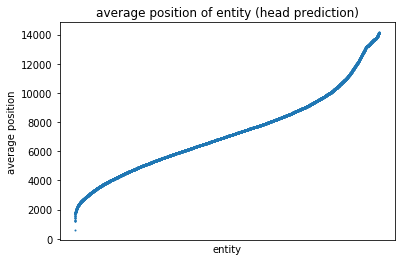

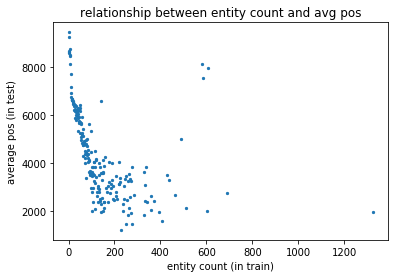

In [21]:
# analyse avg_position_table_head.pkl
path = os.path.join(model_output_path, 'avg_position_table_head.pkl')
avg_position_table_head = pd.read_pickle(path)

count_entities_highest = dict()  # train data
count_entities_highest_t = dict()  # test data
for entity_id in avg_position_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]
    count_entities_highest_t[entity_name] = count_head_entities_test[entity_id]

count_entities_lowest = dict()
count_entities_lowest_t = dict()
for entity_id in avg_position_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]
    count_entities_lowest_t[entity_name] = count_head_entities_test[entity_id]

print('\nstatistical values:')
display(avg_position_table_head.describe().round(1))
print('\n\nentities with lowest average position (top 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_head_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_head_tmp['entity_name'] = entity_names
avg_position_table_head_tmp['average position'] = average_positions

avg_position_table_head_tmp['count head in train'] = avg_position_table_head_tmp['entity_name'].\
                                                     map(count_entities_highest)
avg_position_table_head_tmp['count head in test'] = avg_position_table_head_tmp['entity_name'].\
                                                    map(count_entities_highest_t)
display(avg_position_table_head_tmp.style.hide_index())
print('Hint: \"count head in train\" = number of occurrences of the entities in the training data (as head)')
print('\"count head in test\" = number of occurrences of the entities in the test data (as head)')

print('\n\nentities with highest average position (last 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_head_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_head_tmp['entity_name'] = entity_names
avg_position_table_head_tmp['average position'] = average_positions

avg_position_table_head_tmp['count head in train'] = avg_position_table_head_tmp['entity_name'].\
                                                     map(count_entities_lowest)
avg_position_table_head_tmp['count head in test'] = avg_position_table_head_tmp['entity_name'].\
                                                    map(count_entities_lowest_t)
display(avg_position_table_head_tmp.style.hide_index())
print()

y = avg_position_table_head['average position']
x = np.arange(len(y))
plt.figure()
plt.title('average position of entity (head prediction)')
plt.xlabel('entity')
plt.ylabel('average position')
plt.xticks([])
plt.scatter(x, y, s=1)
plt.show()

entity_count_to_avg_pos = dict()
for index, row in avg_position_table_head.iterrows():
    entity_count = count_head_entities_train[row['entity_id']]
    if entity_count not in entity_count_to_avg_pos:
        entity_count_to_avg_pos[entity_count] = (row['average position'], 1)
    else:
        entity_count_to_avg_pos[entity_count] = (entity_count_to_avg_pos[entity_count][0]
                                                 + row['average position'],
                                                 entity_count_to_avg_pos[entity_count][1] + 1)

for entity_count, (sum_avg_pos, num) in entity_count_to_avg_pos.items():
    entity_count_to_avg_pos[entity_count] = sum_avg_pos / num

x = []
y = []
for entity_count in sorted(entity_count_to_avg_pos):
    x.append(entity_count)
    y.append(entity_count_to_avg_pos[entity_count])    
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id

plt.figure()
plt.title('relationship between entity count and avg pos')
plt.xlabel('entity count (in train)')
plt.ylabel('average pos (in test)')
plt.scatter(x, y, s=5)
plt.show()


statistical values:



,entity_id,average position
count,14541.0,14541.0
mean,7270.0,7270.0
std,4197.8,3068.4
min,0.0,410.0
25%,3635.0,4949.1
50%,7270.0,7037.0
75%,10905.0,9320.2
max,14540.0,14503.0




entities with lowest average position (top 10):


entity_name,average position,count tail in train,count tail in test
10191,410,3612,402
HBO,807,29,0
Library of Congress Classification,887,411,50
NBC,942,50,4
Warner Bros.,979,181,3
The Walt Disney Company,1051,45,2
marriage,1076,2586,299
male organism,1085,2928,333
Universal Pictures,1110,139,5
BBC,1119,22,3


Hint: "count tail in train" = number of occurrences of the entities in the training data (as tail)
"count tail in test" = number of occurrences of the entities in the test data (as tail)


entities with highest average position (last 10):


entity_name,average position,count tail in train,count tail in test
Vice President of the United States,14480,0,0
Canadian Army,14497,1,0
Canadian Armed Forces,14498,0,0
Royal Canadian Air Force,14498,1,0
afrobeat,14498,0,0
African popular music,14499,1,0
bay,14499,1,0
bay,14500,1,0
Modernism,14503,0,0
modern architecture,14503,1,0


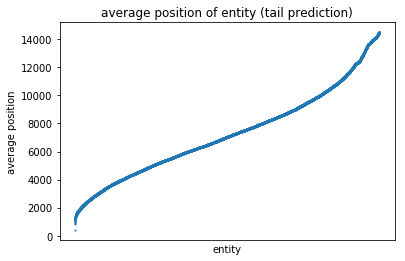

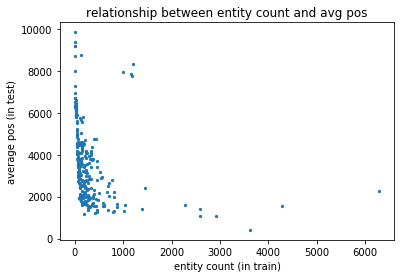

In [22]:
# analyse avg_position_table_tail.pkl
path = os.path.join(model_output_path, 'avg_position_table_tail.pkl')
avg_position_table_tail = pd.read_pickle(path)

count_entities_highest = dict()  # train data
count_entities_highest_t = dict()  # test data
for entity_id in avg_position_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]
    count_entities_highest_t[entity_name] = count_tail_entities_test[entity_id]

count_entities_lowest = dict()
count_entities_lowest_t = dict()
for entity_id in avg_position_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]
    count_entities_lowest_t[entity_name] = count_tail_entities_test[entity_id]

print('\nstatistical values:\n')
display(avg_position_table_tail.describe().round(1))

print('\n\nentities with lowest average position (top 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_tail_tmp['entity_name'] = entity_names
avg_position_table_tail_tmp['average position'] = average_positions

avg_position_table_tail_tmp['count tail in train'] = avg_position_table_tail_tmp['entity_name'].\
                                                     map(count_entities_highest)
avg_position_table_tail_tmp['count tail in test'] = avg_position_table_tail_tmp['entity_name'].\
                                                    map(count_entities_highest_t)
display(avg_position_table_tail_tmp.style.hide_index())
print('Hint: \"count tail in train\" = number of occurrences of the entities in the training data (as tail)')
print('\"count tail in test\" = number of occurrences of the entities in the test data (as tail)')

print('\n\nentities with highest average position (last 10):')
entity_names = []
average_positions = []
for index, row in avg_position_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    average_positions.append(row['average position'])
average_positions = [round(avg_pos) for avg_pos in average_positions]
avg_position_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'average position'])
avg_position_table_tail_tmp['entity_name'] = entity_names
avg_position_table_tail_tmp['average position'] = average_positions

avg_position_table_tail_tmp['count tail in train'] = avg_position_table_tail_tmp['entity_name'].\
                                                     map(count_entities_lowest)
avg_position_table_tail_tmp['count tail in test'] = avg_position_table_tail_tmp['entity_name'].\
                                                    map(count_entities_lowest_t)
display(avg_position_table_tail_tmp.style.hide_index())
print()

y = avg_position_table_tail['average position']
x = np.arange(len(y))
plt.figure()
plt.title('average position of entity (tail prediction)')
plt.xlabel('entity')
plt.ylabel('average position')
plt.xticks([])
plt.scatter(x, y, s=1)
plt.show()

entity_count_to_avg_pos = dict()
for index, row in avg_position_table_tail.iterrows():
    entity_count = count_tail_entities_train[row['entity_id']]
    if entity_count not in entity_count_to_avg_pos:
        entity_count_to_avg_pos[entity_count] = (row['average position'], 1)
    else:
        entity_count_to_avg_pos[entity_count] = (entity_count_to_avg_pos[entity_count][0] +
                                                 row['average position'],
                                                 entity_count_to_avg_pos[entity_count][1] + 1)

for entity_count, (sum_avg_pos, num) in entity_count_to_avg_pos.items():
    entity_count_to_avg_pos[entity_count] = sum_avg_pos / num

x = []
y = []
for entity_count in sorted(entity_count_to_avg_pos):
    x.append(entity_count)
    y.append(entity_count_to_avg_pos[entity_count])

plt.figure()
plt.title('relationship between entity count and avg pos')
plt.xlabel('entity count (in train)')
plt.ylabel('average pos (in test)')
plt.scatter(x, y, s=5)
plt.show()

In [23]:
# analyse highly_ranked_table_head.pkl
path = os.path.join(model_output_path, 'highly_ranked_table_head.pkl')
highly_ranked_table_head = pd.read_pickle(path)

entity_in_top10_count_head = defaultdict(int)
for index, row in highly_ranked_table_head.iterrows():
    entity_in_top10_count_head[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in highly_ranked_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in highly_ranked_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]

print('\nstatistical values:\n')
display(highly_ranked_table_head.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity gets a position between 1 and 10)\n')
entity_names = []
counts = []
for index, row in highly_ranked_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_head_tmp['entity_name'] = entity_names
highly_ranked_table_head_tmp['count'] = counts

highly_ranked_table_head_tmp['count head in train'] = highly_ranked_table_head_tmp['entity_name'].\
                                                      map(count_entities_highest)
display(highly_ranked_table_head_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity gets a position between 1 and 10)\n')
entity_names = []
counts = []
for index, row in highly_ranked_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_head_tmp['entity_name'] = entity_names
highly_ranked_table_head_tmp['count'] = counts

highly_ranked_table_head_tmp['count head in train'] = highly_ranked_table_head_tmp['entity_name'].\
                                                      map(count_entities_lowest)
display(highly_ranked_table_head_tmp.style.hide_index())

mask = highly_ranked_table_head['count'] > 100
num = highly_ranked_table_head[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = highly_ranked_table_head['count'] == 0
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = highly_ranked_table_head['count'] == 1
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = highly_ranked_table_head['count'] < 10
num = highly_ranked_table_head[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,10497.0,10497.0
mean,7228.5,19.5
std,4177.1,45.6
min,2.0,1.0
25%,3632.0,2.0
50%,7216.0,6.0
75%,10866.0,17.0
max,14536.0,1165.0




entities with highest count (top 10)
(shows how often the respective entity gets a position between 1 and 10)



entity_name,count,count head in train
10191,1165,0
United States of America,1084,1325
New York City,781,67
Los Angeles,773,55
California,753,175
Library of Congress Classification,612,0
20th Century Fox,579,230
Madonna,538,99
marriage,518,406
New York University Tisch School of the Arts,495,40




entities with lowest count (last 10)
(shows how often the respective entity gets a position between 1 and 10)



entity_name,count,count head in train
High Anxiety,1,17
Robots,1,13
bladder cancer,1,7
Tony Award for Best Choreography,1,3
The Cider House Rules,1,22
Gettysburg,1,4
Pennsylvania Academy of the Fine Arts,1,1
Harrisburg,1,7
University of Pennsylvania Law School,1,7
Chuck Berry,1,6



number of entities with count > 100: 389
number of entities with count 0: 0
number of entities with count 1: 1771
number of entities with count < 10: 6479


In [24]:
# analyse highly_ranked_table_tail.pkl
path = os.path.join(model_output_path, 'highly_ranked_table_tail.pkl')
highly_ranked_table_tail = pd.read_pickle(path)

entity_in_top10_count_tail = defaultdict(int)
for index, row in highly_ranked_table_tail.iterrows():
    entity_in_top10_count_tail[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in highly_ranked_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]
    
count_entities_lowest = dict()
for entity_id in highly_ranked_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]

print('\nstatistical values:\n')
display(highly_ranked_table_tail.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity gets a position between 1 and 10)')
entity_names = []
counts = []
for index, row in highly_ranked_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_tail_tmp['entity_name'] = entity_names
highly_ranked_table_tail_tmp['count'] = counts

highly_ranked_table_tail_tmp['count tail in train'] = highly_ranked_table_tail_tmp['entity_name'].\
                                                      map(count_entities_highest)
display(highly_ranked_table_tail_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity gets a position between 1 and 10)')
entity_names = []
counts = []
for index, row in highly_ranked_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
highly_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
highly_ranked_table_tail_tmp['entity_name'] = entity_names
highly_ranked_table_tail_tmp['count'] = counts

highly_ranked_table_tail_tmp['count tail in train'] = highly_ranked_table_tail_tmp['entity_name'].\
                                                      map(count_entities_lowest)
display(highly_ranked_table_tail_tmp.style.hide_index())

mask = highly_ranked_table_tail['count'] > 100
num = highly_ranked_table_tail[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = highly_ranked_table_tail['count'] == 0
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = highly_ranked_table_tail['count'] == 1
num = highly_ranked_table_tail[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = highly_ranked_table_tail['count'] < 10
num = highly_ranked_table_tail[mask].shape[0]
# print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,10288.0,10288.0
mean,7251.6,19.9
std,4207.7,77.2
min,2.0,1.0
25%,3627.5,2.0
50%,7245.5,5.0
75%,10900.2,14.0
max,14539.0,2887.0




entities with highest count (top 10)
(shows how often the respective entity gets a position between 1 and 10)


entity_name,count,count tail in train
10191,2887,3612
Library of Congress Classification,2087,411
male organism,1967,2928
United States of America,1844,6289
marriage,1768,2586
female organism,1366,811
New York City,1239,1010
actor,1225,2271
Canada,1175,683
Los Angeles,1167,684




entities with lowest count (last 10)
(shows how often the respective entity gets a position between 1 and 10)


entity_name,count,count tail in train
August Strindberg,1,7
Abe Burrows,1,6
Ron Weiner,1,27
Danny Trejo,1,1
Gettysburg,1,3
Harrisburg,1,6
Clinton County,1,3
Carthage,1,2
Sicily,1,5
Ancient Greece,1,2



number of entities with count > 100: 308
number of entities with count 0: 0
number of entities with count 1: 1773


In [25]:
# analyse top_ranked_table_head.pkl
path = os.path.join(model_output_path, 'top_ranked_table_head.pkl')
top_ranked_table_head = pd.read_pickle(path)

entity_first_place_count_head = defaultdict(int)
for index, row in top_ranked_table_head.iterrows():
    entity_first_place_count_head[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in top_ranked_table_head['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_head_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in top_ranked_table_head['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_head_entities_train[entity_id]

print('\nstatistical values:\n')
display(top_ranked_table_head.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity is on the first place in models ranking)\n')
entity_names = []
counts = []
for index, row in top_ranked_table_head.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_head_tmp['entity_name'] = entity_names
top_ranked_table_head_tmp['count'] = counts

top_ranked_table_head_tmp['count head in train'] = top_ranked_table_head_tmp['entity_name'].\
                                                   map(count_entities_highest)
display(top_ranked_table_head_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity is on the first place in models ranking)\n')
entity_names = []
counts = []
for index, row in top_ranked_table_head.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_head_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_head_tmp['entity_name'] = entity_names
top_ranked_table_head_tmp['count'] = counts

top_ranked_table_head_tmp['count head in train'] = top_ranked_table_head_tmp['entity_name'].\
                                                   map(count_entities_lowest)
display(top_ranked_table_head_tmp.style.hide_index())

mask = top_ranked_table_head['count'] > 100
num = top_ranked_table_head[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = top_ranked_table_head['count'] == 0
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = top_ranked_table_head['count'] == 1
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = top_ranked_table_head['count'] < 10
num = top_ranked_table_head[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,4271.0,4271.0
mean,7216.0,4.8
std,4096.4,15.7
min,3.0,1.0
25%,3721.5,1.0
50%,7333.0,2.0
75%,10726.5,3.0
max,14536.0,440.0




entities with highest count (top 10)
(shows how often the respective entity is on the first place in models ranking)



entity_name,count,count head in train
10191,440,0
Courtney Love,327,42
William Shatner,300,38
Liev Schreiber,299,32
Barack Obama,278,32
United States of America,257,1325
"Crouching Tiger, Hidden Dragon",194,74
The Social Network,157,92
2012,141,96
Hugo,136,69




entities with lowest count (last 10)
(shows how often the respective entity is on the first place in models ranking)



entity_name,count,count head in train
Dan Wilson,1,30
Blazing Saddles,1,17
Tony Award for Best Direction of a Musical,1,8
Yul Brynner,1,7
political satire,1,0
Rachel Weisz,1,30
Barry Pepper,1,36
Monster,1,17
Williamsport,1,4
Terry Gilliam,1,29



number of entities with count > 100: 13
number of entities with count 0: 0
number of entities with count 1: 1990
number of entities with count < 10: 3889


In [26]:
# analyse top_ranked_table_tail.pkl
path = os.path.join(model_output_path, 'top_ranked_table_tail.pkl')
top_ranked_table_tail = pd.read_pickle(path)

entity_first_place_count_tail = defaultdict(int)
for index, row in top_ranked_table_tail.iterrows():
    entity_first_place_count_tail[row['entity_id']] = row['count']

count_entities_highest = dict()
for entity_id in top_ranked_table_tail['entity_id'].head(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_highest[entity_name] = count_tail_entities_train[entity_id]

count_entities_lowest = dict()
for entity_id in top_ranked_table_tail['entity_id'].tail(10):
    try:
        entity_name = mid2name[id2entity[entity_id]]
    except:
        entity_name = entity_id
    count_entities_lowest[entity_name] = count_tail_entities_train[entity_id]

print('\nstatistical values:\n')
display(top_ranked_table_tail.describe().round(1))

print('\n\nentities with highest count (top 10)')
print('(shows how often the respective entity is on the first place in models ranking)')
entity_names = []
counts = []
for index, row in top_ranked_table_tail.head(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_tail_tmp['entity_name'] = entity_names
top_ranked_table_tail_tmp['count'] = counts

top_ranked_table_tail_tmp['count tail in train'] = top_ranked_table_tail_tmp['entity_name'].\
                                                   map(count_entities_highest)
display(top_ranked_table_tail_tmp.style.hide_index())

print('\n\nentities with lowest count (last 10)')
print('(shows how often the respective entity is on the first place in models ranking)')
entity_names = []
counts = []
for index, row in top_ranked_table_tail.tail(10).iterrows():
    try:
        entity_name = mid2name[id2entity[row['entity_id']]]
    except:
        entity_name = row['entity_id']
    entity_names.append(entity_name)
    counts.append(row['count'])
top_ranked_table_tail_tmp = pd.DataFrame(columns=['entity_name', 'count'])
top_ranked_table_tail_tmp['entity_name'] = entity_names
top_ranked_table_tail_tmp['count'] = counts

top_ranked_table_tail_tmp['count tail in train'] = top_ranked_table_tail_tmp['entity_name'].\
                                                   map(count_entities_lowest)
display(top_ranked_table_tail_tmp.style.hide_index())

mask = top_ranked_table_tail['count'] > 100
num = top_ranked_table_tail[mask].shape[0]
print('\nnumber of entities with count > 100: ' + str(num))

mask = top_ranked_table_tail['count'] == 0
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count 0: ' + str(num))

mask = top_ranked_table_tail['count'] == 1
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count 1: ' + str(num))

mask = top_ranked_table_tail['count'] < 10
num = top_ranked_table_tail[mask].shape[0]
print('number of entities with count < 10: ' + str(num))


statistical values:



,entity_id,count
count,4074.0,4074.0
mean,7212.0,5.0
std,4095.9,20.2
min,5.0,1.0
25%,3752.2,1.0
50%,7283.5,2.0
75%,10732.5,4.0
max,14539.0,746.0




entities with highest count (top 10)
(shows how often the respective entity is on the first place in models ranking)


entity_name,count,count tail in train
United States of America,746,6289
10191,471,3612
male organism,340,2928
English,331,2590
marriage,283,2586
United States dollar,265,4285
United Kingdom,209,1443
New York City,202,1010
Los Angeles,198,684
actor,190,2271




entities with lowest count (last 10)
(shows how often the respective entity is on the first place in models ranking)


entity_name,count,count tail in train
81st Academy Awards,1,19
David Brown,1,15
Atom Egoyan,1,7
J. D. Salinger,1,6
Kevin Kline,1,25
Sweeney Todd: The Demon Barber of Fleet Street,1,26
Rose McGowan,1,8
1622,1,11
Williamsport,1,4
Superbad,1,11



number of entities with count > 100: 18
number of entities with count 0: 0
number of entities with count 1: 1946
number of entities with count < 10: 3724


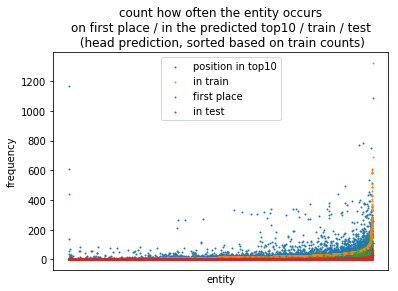

most intersting section:


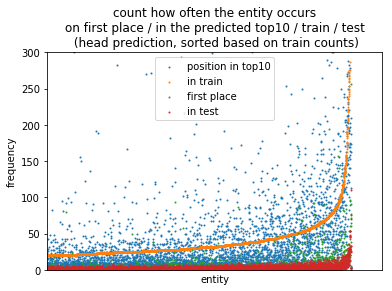


entities that were predicted far too often:


entity,true head count,pred head count,difference,head in train count,entity in train count
10191,0,440,440,0,3612
Courtney Love,4,327,323,42,74
Liev Schreiber,1,299,298,32,45
William Shatner,3,300,297,38,61
Barack Obama,1,278,277,32,63
"Crouching Tiger, Hidden Dragon",8,194,186,74,121
The Social Network,7,157,150,92,138
United States of America,110,257,147,1325,7614
2012,7,141,134,96,110
Hugo,5,136,131,69,115




entities that were predicted far too seldom:


entity,true head count,pred head count,difference,head in train count,entity in train count
drum kit,45,20,-25,338,516
3106,30,17,-13,236,296
The Hunger Games,14,1,-13,68,81
Academy Award for Best Cinematography,27,15,-12,245,339
"Academy Award for Best Writing, Adapted...",29,18,-11,276,429
The Pianist,12,1,-11,56,81
BAFTA Award for Best Film,23,12,-11,219,400
Wreck-It Ralph,12,1,-11,50,62
BAFTA Award for Best Editing,12,2,-10,150,190
Sherlock Holmes,13,3,-10,74,94


In [27]:
# head prediction: plot how often the entity occurs in the predicted top10 / on first place / train / 
# test (sorted based on train counts)
y_train = []
y_test = []
y_predicted_top10 = []
y_predicted_top1 = []

all_entities = list(id2entity.keys())
all_head_entities_train = list(count_head_entities_train.keys())
entities_not_head_in_train = np.setdiff1d(all_entities, all_head_entities_train)
assert len(all_entities) == len(entities_not_head_in_train) + len(all_head_entities_train)

for entity_id in entities_not_head_in_train:
    y_train.append(count_head_entities_train[entity_id])
    y_test.append(count_head_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_head[entity_id])
    y_predicted_top1.append(entity_first_place_count_head[entity_id])

for entity_id in sorted(count_head_entities_train, key=count_head_entities_train.get):
    y_train.append(count_head_entities_train[entity_id])
    y_test.append(count_head_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_head[entity_id])
    y_predicted_top1.append(entity_first_place_count_head[entity_id])
    
assert len(y_train) == len(y_test)
assert len(y_test) == len(y_predicted_top10)
assert len(y_test) == len(y_predicted_top1)
x = [i for i in range(len(y_train))]

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (head prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.show()

print('most intersting section:')

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (head prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.axis([10000, 15000, 0, 300])  # xmin, xmax, ymin, ymax
plt.show()

entity_ids = []
differences = []  # difference between count predicted and count true
true_head_counts = []
pred_head_counts = []
head_in_train_counts = []
entity_in_train_counts = []

for entity_id in id2entity.keys():
    entity_ids.append(entity_id)
    true_head_counts.append(count_head_entities_test[entity_id])
    pred_head_counts.append(entity_first_place_count_head[entity_id])
    difference = entity_first_place_count_head[entity_id] - count_head_entities_test[entity_id]
    differences.append(difference)
    head_in_train_counts.append(count_head_entities_train[entity_id])
    entity_in_train_counts.append(count_head_entities_train[entity_id]
                                  + count_tail_entities_train[entity_id])

entity_names = []
for entity_id in entity_ids:
    try:
        entity_name = mid2name[id2entity[entity_id]]
        if len(entity_name) > 39:
            entity_name = entity_name[:39] + '...'
        entity_names.append(entity_name)
    except:
        entity_names.append(entity_id)

difference_df = pd.DataFrame(columns=['entity', 'true head count', 'pred head count', 'difference', 
                                      'head in train count', 'entity in train count'])
difference_df['entity'] = entity_names
difference_df['true head count'] = true_head_counts
difference_df['pred head count'] = pred_head_counts
difference_df['difference'] = differences
difference_df['head in train count'] = head_in_train_counts
difference_df['entity in train count'] = entity_in_train_counts
difference_df = difference_df.sort_values(by='difference', ascending=False)

print('\nentities that were predicted far too often:')
display(difference_df.head(10).style.hide_index())
print('\n\nentities that were predicted far too seldom:')
display(difference_df.tail(10).sort_values(by='difference').style.hide_index())

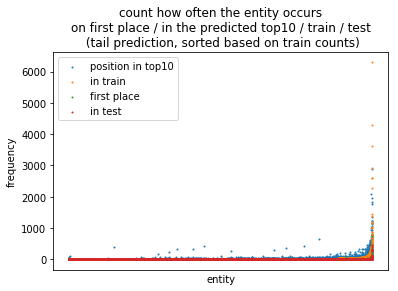

most intersting section:


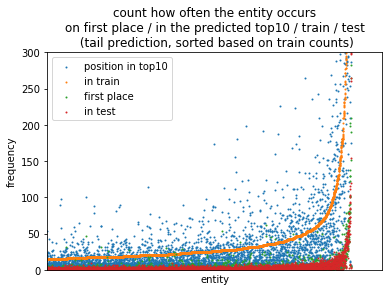


entities that were predicted far too often:


entity,true tail count,pred tail count,difference,tail in train count,entity in train count
United States of America,454,746,292,6289,7614
New York City,73,202,129,1010,1077
Los Angeles,73,198,125,684,739
United Kingdom,120,209,89,1443,1953
10191,402,471,69,3612,3612
Canada,65,129,64,683,877
Germany,67,130,63,705,861
Bonnie Raitt,0,62,62,34,66
France,49,102,53,772,982
Kansas City,1,53,52,27,36




entities that were predicted far too seldom:


entity,true tail count,pred tail count,difference,tail in train count,entity in train count
actor,261,190,-71,2271,2272
Finland,55,27,-28,392,471
Israel,35,9,-26,250,279
Austria,29,8,-21,232,316
Argentina,46,26,-20,376,421
Japan,59,40,-19,528,629
Indonesia,19,1,-18,106,138
Library of Congress Classification,50,33,-17,411,411
Denmark,51,34,-17,360,415
Hong Kong,36,19,-17,360,406


In [28]:
# tail prediction: plot how often the entity occurs in the predicted top10 / on first place / train /
# test (sorted based on train counts)
y_train = []
y_test = []
y_predicted_top10 = []
y_predicted_top1 = []

all_tail_entities_train = list(count_tail_entities_train.keys())
entities_not_tail_in_train = np.setdiff1d(all_entities, all_tail_entities_train)
assert len(all_entities) == len(entities_not_tail_in_train) + len(all_tail_entities_train)

for entity_id in entities_not_tail_in_train:
    y_train.append(count_tail_entities_train[entity_id])
    y_test.append(count_tail_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_tail[entity_id])
    y_predicted_top1.append(entity_first_place_count_tail[entity_id])

for entity_id in sorted(count_tail_entities_train, key=count_tail_entities_train.get):
    y_train.append(count_tail_entities_train[entity_id])
    y_test.append(count_tail_entities_test[entity_id])
    y_predicted_top10.append(entity_in_top10_count_tail[entity_id])
    y_predicted_top1.append(entity_first_place_count_tail[entity_id])
    
assert len(y_train) == len(y_test)
assert len(y_test) == len(y_predicted_top10)
assert len(y_test) == len(y_predicted_top1)
x = [i for i in range(len(y_train))]

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (tail prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.show()

print('most intersting section:')

plt.figure()
plt.title('count how often the entity occurs\non first place / in the predicted top10 / train / ' \
          + 'test\n (tail prediction, sorted based on train counts)')
plt.xlabel('entity')
plt.ylabel('frequency')
plt.xticks([])

plt.scatter(x, y_predicted_top10, label='position in top10', s=1)
plt.scatter(x, y_train, label='in train', s=1)
plt.scatter(x, y_predicted_top1, label='first place', s=1)
plt.scatter(x, y_test, label='in test', s=1)
plt.legend()
plt.axis([10000, 15000, 0, 300])  # xmin, xmax, ymin, ymax
plt.show()

entity_ids = []
differences = []  # difference between count predicted and count true
true_tail_counts = []
pred_tail_counts = []
tail_in_train_counts = []
entity_in_train_counts = []

for entity_id in id2entity.keys():
    entity_ids.append(entity_id)
    true_tail_counts.append(count_tail_entities_test[entity_id])
    pred_tail_counts.append(entity_first_place_count_tail[entity_id])
    difference = entity_first_place_count_tail[entity_id] - count_tail_entities_test[entity_id]
    differences.append(difference)
    tail_in_train_counts.append(count_tail_entities_train[entity_id])
    entity_in_train_counts.append(count_head_entities_train[entity_id]
                                  + count_tail_entities_train[entity_id])

entity_names = []
for entity_id in entity_ids:
    try:
        entity_name = mid2name[id2entity[entity_id]]
        if len(entity_name) > 39:
            entity_name = entity_name[:39] + '...'
        entity_names.append(entity_name)
    except:
        entity_names.append(entity_id)

difference_df = pd.DataFrame(columns=['entity', 'true tail count', 'pred tail count', 'difference', 
                                      'tail in train count', 'entity in train count'])
difference_df['entity'] = entity_names
difference_df['true tail count'] = true_tail_counts
difference_df['pred tail count'] = pred_tail_counts
difference_df['difference'] = differences
difference_df['tail in train count'] = tail_in_train_counts
difference_df['entity in train count'] = entity_in_train_counts
difference_df = difference_df.sort_values(by='difference', ascending=False)

print('\nentities that were predicted far too often:')
display(difference_df.head(10).style.hide_index())
print('\n\nentities that were predicted far too seldom:')
display(difference_df.tail(10).sort_values(by='difference').style.hide_index())